# Time Series Forecasting - Jena Climate Dataset 

### Project Goals

This project leverages the Jena Climate Dataset to explore and predict key climate variables, temperature, using a variety of machine learning and deep learning models.

By analyzing features such as time, atmospheric pressure, and other related variables, this project aims to develop robust predictive models that can accurately forecast these critical climate metrics.

Throughout this project, several machine learning techniques, including linear regression and random forests, as well as advanced deep learning models like Long Short-Term Memory (LSTM) networks, will be employed. Each model will be evaluated for its predictive performance, and the results will be compared to determine the most effective approach for climate prediction.

This project not only demonstrates the application of data science to real-world climate data but also highlights the potential of predictive modeling in contributing to our understanding of climate dynamics and aiding in environmental decision-making.

### Dataset Information

**Context**

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

**Content**

Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

Below are the variables for the dataset: 

Variable  |Description |
-----|-----| 
Date Time|Date-time reference|
p (mbar)|The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.|
T (degC)|Temperature in Celsius|
Tpot (K)|Temperature in Kelvin|
Tdew (degC)|Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.|
rh (%)|Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.|
VPmax (mbar)|Saturation vapor pressure|
VPact (mbar)|Vapor pressure|
VPdef (mbar)|Vapor pressure deficit|
sh (g/kg)|Specific humidity|
H2OC (mmol/mol)|Water vapor concentration|
rho (g/m ** 3)|	Airtight|
wv (m/s)|Wind speed|
max. wv (m/s)|Maximum wind speed|
wd (deg)|Wind direction in degrees|

In [121]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from math import sqrt
import pickle
import joblib
from joblib import dump, load

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error as mse, r2_score as r2, mean_absolute_error as mae

import tensorflow as tf 
from tensorflow.keras.models import load_model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [5]:
df = pd.read_csv(r"C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\jena_climate_2009_2016.csv")

In [6]:
df.shape

(420551, 15)

In [7]:
# Reducing the dataset such that the datetime is on an hourly basis
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [8]:
data = df.copy()

In [9]:
# Converting the date time to the correct format
data['Date Time'] = pd.to_datetime(data['Date Time'], format="%d.%m.%Y %H:%M:%S")

# Extracting hour of the day
Hour = data['Date Time'].dt.hour

# Extracting day of the year
DayOfYear = data['Date Time'].dt.dayofyear

# Extracting day of the week
DayOfWeek = data['Date Time'].dt.dayofweek

# Extracting month
Month = data['Date Time'].dt.month

# Sinusoidal encoding for the hour of the day 
data['Hour_sin'] = np.sin(2 * np.pi * Hour / 24)
data['Hour_cos'] = np.cos(2 * np.pi * Hour / 24)

# Sinusoidal encodings for day of the week
data['DayOfWeek_sin'] = np.sin(2 * np.pi * DayOfWeek / 7)
data['DayOfWeek_cos'] = np.cos(2 * np.pi * DayOfWeek / 7)

# Sinusoidal encodings for the day of the year
data['DayOfYear_sin'] = np.sin(2 * np.pi * DayOfYear / 365.2425)
data['DayOfYear_cos'] = np.cos(2 * np.pi * DayOfYear / 365.2425)

# Dropping Date Time column
data = data.drop(['Date Time'], axis = 1)

# We know that Tpot (K) is just the conversion of T (degC) in Kelvin, so we will just drop it, as it won't be useful for modelling purposes.
data = data.drop(['Tpot (K)'], axis = 1)

In [10]:
data.head()

,p (mbar),T (degC),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos
5,996.50,-8.05,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,0.258819,0.965926,0.433884,-0.900969,0.017202,0.999852
11,996.62,-8.88,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,0.500000,0.866025,0.433884,-0.900969,0.017202,0.999852
17,996.84,-8.81,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,0.707107,0.707107,0.433884,-0.900969,0.017202,0.999852
23,996.99,-9.05,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,0.866025,0.500000,0.433884,-0.900969,0.017202,0.999852
29,997.46,-9.63,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,0.965926,0.258819,0.433884,-0.900969,0.017202,0.999852


Looking at our dataset, we know that there high multicolinearity between variables. However, for the purpose of testing, we will leave them in and continue to model using Lasso, Ridge, ElasticNet, GradientBoosting and RandomForest.

In [12]:
# Splitting our data
X0 = data.drop(['T (degC)'], axis = 1)
y0 = data['T (degC)']

# Customised train/test split
X_train0, y_train0 = X0[:60000], y0[:60000]
X_val0, y_val0 = X0[60000:65000], y0[60000:65000]
X_test0, y_test0 = X0[65000:], y0[65000:]

X_train0.shape, y_train0.shape, X_val0.shape, y_val0.shape, X_test0.shape, y_test0.shape

((60000, 18), (60000,), (5000, 18), (5000,), (5091, 18), (5091,))

In [13]:
print("Train data date range:", X0.index[0], "to", X0.index[-1])
print("Validation data date range:", X0.index[60000], "to", X0.index[64999])
print("Test data date range:", X0.index[65000], "to", X0.index[-1])

Train data date range: 5 to 420545
Validation data date range: 360005 to 389999
Test data date range: 390005 to 420545


In [107]:
# Parameter grids for each model
param_grid_ridge = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_en = {
    'model__alpha': [0.1, 1, 10],
    'model__l1_ratio': [0.1, 0.5, 0.9]
}
param_grid_gb = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__max_depth': [3, 5, 7, 9]
}
param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Pipelines for each model
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', Ridge(random_state=42))
])

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', Lasso(random_state=42))
])

pipeline_en = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', ElasticNet(max_iter = 1000, random_state=42))
])

pipeline_gb = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', GradientBoostingRegressor(random_state=42))
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', RandomForestRegressor(random_state=42))
])

In [15]:
# GridSearchCV for Ridge Regression
grid_search_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose =1)
grid_search_ridge.fit(X_train0, y_train0)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge(random_state=42))]),
             n_jobs=-1, param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
# GridSearchCV for Lasso Regression
grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose =1)
grid_search_lasso.fit(X_train0, y_train0)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso(random_state=42))]),
             n_jobs=-1, param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [17]:
# GridSearchCV for ElasticNet Regression
grid_search_en = GridSearchCV(pipeline_en, param_grid_en, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose =1)
grid_search_en.fit(X_train0, y_train0)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', ElasticNet(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 1, 10],
                         'model__l1_ratio': [0.1, 0.5, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
# GridSearchCV for Gradient Boosting Regressor
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=3, scoring='neg_mean_squared_error', verbose =1)
grid_search_gb.fit(X_train0, y_train0)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1],
                         'model__max_depth': [3, 5, 7, 9],
                         'model__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [111]:
# GridSearchCV for Random Forest Regressor
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose =3, n_jobs=8)
grid_search_rf.fit(X_train0, y_train0)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=8,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=3)

In [113]:
filepath_search = r'C:\\Users\\Al-Amin\\Desktop\\Data_Analyst_Projects\\Python\\LTSM Time Series Forecasting\\Dataset\\Models_gridsearch'

# Save GridSearchCV objects
dump(grid_search_ridge, filepath_search + '\\grid_search_ridge.joblib')
dump(grid_search_lasso, filepath_search + '\\grid_search_lasso.joblib')
dump(grid_search_en, filepath_search + '\\grid_search_en.joblib')
dump(grid_search_gb, filepath_search + '\\grid_search_gb.joblib')
dump(grid_search_rf, filepath_search + '\\grid_search_rf.joblib')

filepath_model = r'C:\\Users\\Al-Amin\\Desktop\\Data_Analyst_Projects\\Python\\LTSM Time Series Forecasting\\Dataset\\Models_joblib'

dump(grid_search_ridge.best_estimator_, filepath_model + '\\Ridge.joblib')
dump(grid_search_lasso.best_estimator_, filepath_model + '\\Lasso.joblib')
dump(grid_search_en.best_estimator_, filepath_model + '\\ElasticNet.joblib')
dump(grid_search_gb.best_estimator_, filepath_model + '\\GBR.joblib')
dump(grid_search_rf.best_estimator_, filepath_model + '\\RandomForest.joblib')

['C:\\\\Users\\\\Al-Amin\\\\Desktop\\\\Data_Analyst_Projects\\\\Python\\\\LTSM Time Series Forecasting\\\\Dataset\\\\Models_joblib\\RandomForest.joblib']

In [115]:
filepath_search = r'C:\\Users\\Al-Amin\\Desktop\\Data_Analyst_Projects\\Python\\LTSM Time Series Forecasting\\Dataset\\Models_gridsearch'

grid_search_ridge = load(filepath_search + '\\grid_search_ridge.joblib')
grid_search_lasso = load(filepath_search + '\\grid_search_lasso.joblib')
grid_search_en = load(filepath_search + '\\grid_search_en.joblib')
grid_search_gb = load(filepath_search + '\\grid_search_gb.joblib')
grid_search_rf = load(filepath_search + '\\grid_search_rf.joblib')

filepath_model = r'C:\\Users\\Al-Amin\\Desktop\\Data_Analyst_Projects\\Python\\LTSM Time Series Forecasting\\Dataset\\Models_joblib'

ridge_model = load(filepath_model + '\\Ridge.joblib')
lasso_model = load(filepath_model + '\\Lasso.joblib')
en_model = load(filepath_model + '\\ElasticNet.joblib')
gbr_model = load(filepath_model + '\\GBR.joblib')
rf_model = load(filepath_model + '\\RandomForest.joblib')

In [117]:
print("Ridge Best Parameters:", grid_search_ridge.best_params_)
print("Ridge Best Score:", -grid_search_ridge.best_score_)

print("Lasso Best Parameters:", grid_search_lasso.best_params_)
print("Lasso Best Score:", -grid_search_lasso.best_score_)

print("ElasticNet Best Parameters:", grid_search_en.best_params_)
print("ElasticNet Best Score:", -grid_search_en.best_score_)

print("GB Best Parameters:", grid_search_gb.best_params_)
print("GB Best Score:", -grid_search_gb.best_score_)

print("RF Best Parameters:", grid_search_rf.best_params_)
print("RF Best Score:", -grid_search_rf.best_score_)

Ridge Best Parameters: {'model__alpha': 0.01}
Ridge Best Score: 0.008835939451847014
Lasso Best Parameters: {'model__alpha': 0.01}
Lasso Best Score: 0.01169228417728913
ElasticNet Best Parameters: {'model__alpha': 0.1, 'model__l1_ratio': 0.9}
ElasticNet Best Score: 0.1322500665923512
GB Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100}
GB Best Score: 0.0005415816598049243
RF Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
RF Best Score: 0.0008849943273333206


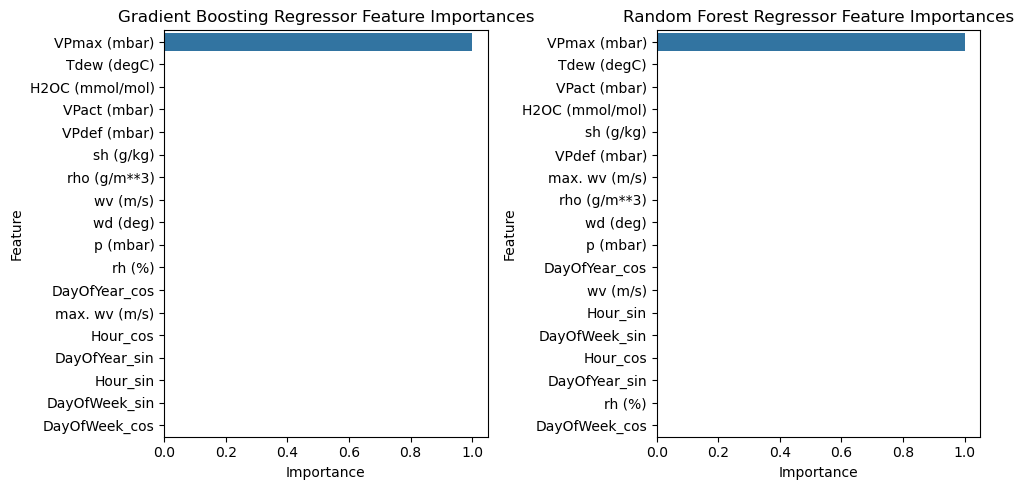

In [131]:
# Extract the best estimator from the GridSearchCV pipeline
gb_model = grid_search_gb.best_estimator_.named_steps['model']

# Extract feature importances
feature_importances_gb = gb_model.feature_importances_ 

# Create a DataFrame for plotting
importance_df_gb = pd.DataFrame({
    'Feature': X_train0.columns,
    'Importance': feature_importances_gb 
})

# Sort by importance
importance_df_gb = importance_df_gb.sort_values(by='Importance', ascending=False)

# Extract the best estimator from the GridSearchCV pipeline
rf_model = grid_search_rf.best_estimator_.named_steps['model']

# Extract feature importances
feature_importances_rf = rf_model.feature_importances_

# Create a DataFrame for plotting
importance_df_rf = pd.DataFrame({
    'Feature': X_train0.columns,
    'Importance': feature_importances_rf
})

# Sort by importance
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 5))

# Gradient Boosting Regressor Feature Importances
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=importance_df_gb)
plt.title('Gradient Boosting Regressor Feature Importances')

# Random Forest Regressor Feature Importances
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Random Forest Regressor Feature Importances')

plt.tight_layout()
plt.show()

Clearly, we can see that VPMax has the most weight on both GB and RF models. 

In order to understand the real impact of thsi feature we would implement feature permutation and column dropping. 

Feature Permutation allows us to assess the relative importance of each feature by measuring performance degradation when features are randomly shuffled. This would help identify which features are critical to the model's performance and which can be safely excluded. 

Column Dropping Methods could be used to systematically evaluate the impact of removing individual features. 

By training models without certain features and comparing performance metrics, it becomes possible to determine which features contribute most significantly to the model's accuracy and which are redundant.

For a more comprehensive feature analysis, combining feature permutation and column dropping methods will provide a clearer picture of feature relevance and model robustness. Implementing these techniques would enable us to make more informed decisions about feature selection and model adjustments, leading to improved generalization and model performance.

In [155]:
def evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test):
    results = []

    for name, model in models.items():
        # Training predictions
        y_train_pred = model.predict(X_train)
        
        # Validation predictions
        y_val_pred = model.predict(X_val)
        
        # Test predictions
        y_test_pred = model.predict(X_test)

        # Metrics for training set
        mse_train = mse(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        mae_train = mae(y_train, y_train_pred)
        r2_train = r2(y_train, y_train_pred)
        adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)

        # Metrics for validation set
        mse_val = mse(y_val, y_val_pred)
        rmse_val = np.sqrt(mse_val)
        mae_val = mae(y_val, y_val_pred)
        r2_val = r2(y_val, y_val_pred)
        adj_r2_val = 1 - (1 - r2_val) * (len(y_val) - 1) / (len(y_val) - X_val.shape[1] - 1)
        
        # Metrics for test set
        mse_test = mse(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mae(y_test, y_test_pred)
        r2_test = r2(y_test, y_test_pred)
        adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
        
        # Append results for each dataset
        results.append({
            'Model': name,
            'Dataset': 'Training',
            'MSE': mse_train,
            'RMSE': rmse_train,
            'MAE': mae_train,
            'R2': r2_train,
            'Adj_R2': adj_r2_train
        })
        
        results.append({
            'Model': name,
            'Dataset': 'Validation',
            'MSE': mse_val,
            'RMSE': rmse_val,
            'MAE': mae_val,
            'R2': r2_val,
            'Adj_R2': adj_r2_val
        })
        
        results.append({
            'Model': name,
            'Dataset': 'Testing',
            'MSE': mse_test,
            'RMSE': rmse_test,
            'MAE': mae_test,
            'R2': r2_test,
            'Adj_R2': adj_r2_test
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

# Call the Function
models = {
    'Ridge': grid_search_ridge,
    'Lasso': grid_search_lasso,
    'ElasticNet': grid_search_en,
    'Gradient Boosting': grid_search_gb,
    'Random Forest': grid_search_rf
}

# Evaluate models and get results
results_df = evaluate_models(models, X_train0, y_train0, X_val0, y_val0, X_test0, y_test0)

# Display the DataFrame
results_df

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,Ridge,Training,0.005402,0.073499,0.045911,0.999925,0.999925
1,Ridge,Validation,0.003435,0.058612,0.043813,0.999904,0.999904
2,Ridge,Testing,0.003077,0.055474,0.037851,0.999956,0.999956
3,Lasso,Training,0.010848,0.104154,0.070389,0.999850,0.999850
4,Lasso,Validation,0.007956,0.089199,0.066536,0.999777,0.999777
5,Lasso,Testing,0.006557,0.080977,0.056681,0.999906,0.999905
6,ElasticNet,Training,0.115171,0.339368,0.229740,0.998409,0.998409
7,ElasticNet,Validation,0.088657,0.297753,0.231329,0.997521,0.997512
8,ElasticNet,Testing,0.053665,0.231658,0.170228,0.999229,0.999226
9,Gradient Boosting,Training,0.000034,0.005821,0.004321,1.000000,1.000000


**Ridge and Lasso Regression**

Training and Validation MSE, RMSE, MAE, R², and Adjusted R² are very close to each other, indicating that both models are not overfitting or underfitting significantly.

However, the Testing performance is slightly better than Validation but not drastically different, which suggests that these models are generalizing well.

**ElasticNet Regression**

The ElasticNet model shows a significant drop in performance on the Training and Validation datasets compared to the Testing dataset.
The Training and Validation errors (MSE, RMSE, MAE) are higher, and the R² is lower, indicating that the model might not be fitting the data as well as it could, which could be a sign of underfitting.


**Gradient Boosting and Random Forest**

Both models show extremely low errors (MSE, RMSE, MAE) across Training, Validation, and Testing datasets, with R² values very close to 1.
This could indicate potential overfitting, especially since the training error is almost zero, and the validation and test errors are still extremely low.

Random Forest in particular shows almost perfect scores on the Testing set, which is uncommon unless the model has learned too much from the training data, potentially leading to overfitting. Essentially, the model might be capturing noise or patterns specific to the training data rather than generalizing well.

### Residual Analysis on the models

While the models appeared to perform well based on the provided metrics, metrics alone do not fully capture a model’s validity. Analyzing residuals is essential for gaining a deeper understanding of the model and capturing a more comprehensive view of its performance.

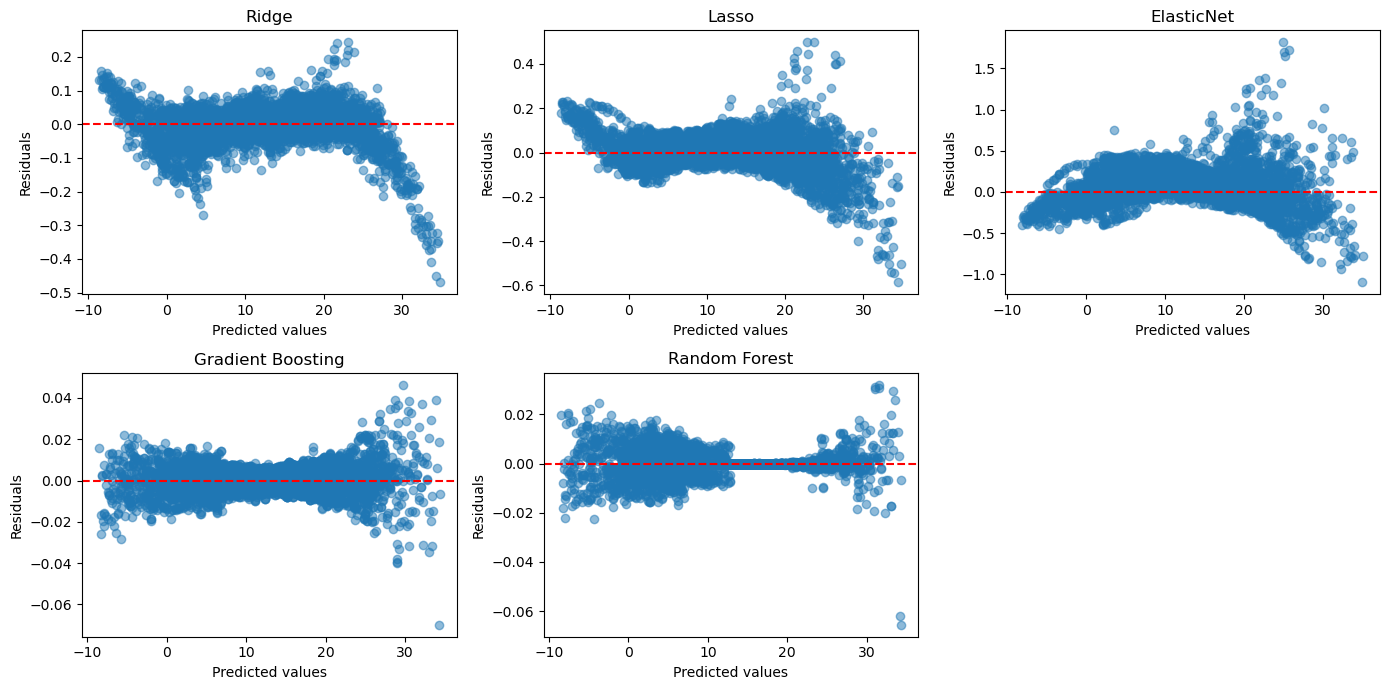

In [157]:
def plot_residuals(models, X_test, y_test):
    plt.figure(figsize=(14, 7))
    
    for name, model in models.items():
        y_test_pred = model.predict(X_test)
        residuals = y_test - y_test_pred
        
        plt.subplot(2, 3, list(models.keys()).index(name) + 1)
        plt.scatter(y_test_pred, residuals, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(name)
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot residuals
plot_residuals(models, X_test0, y_test0)

**Ridge and Lasso:** Since they exhibit an S-shaped curve, they might not be capturing complex patterns. Polynomial features or more advanced models could be explored.

**ElasticNet:** The inverse U-shaped pattern indicates potential underfitting, suggesting that the model could benefit from increased complexity or feature engineering.

**GB and RF:** The X-shaped pattern indicates overfitting. Reducing model complexity or regularization could help.

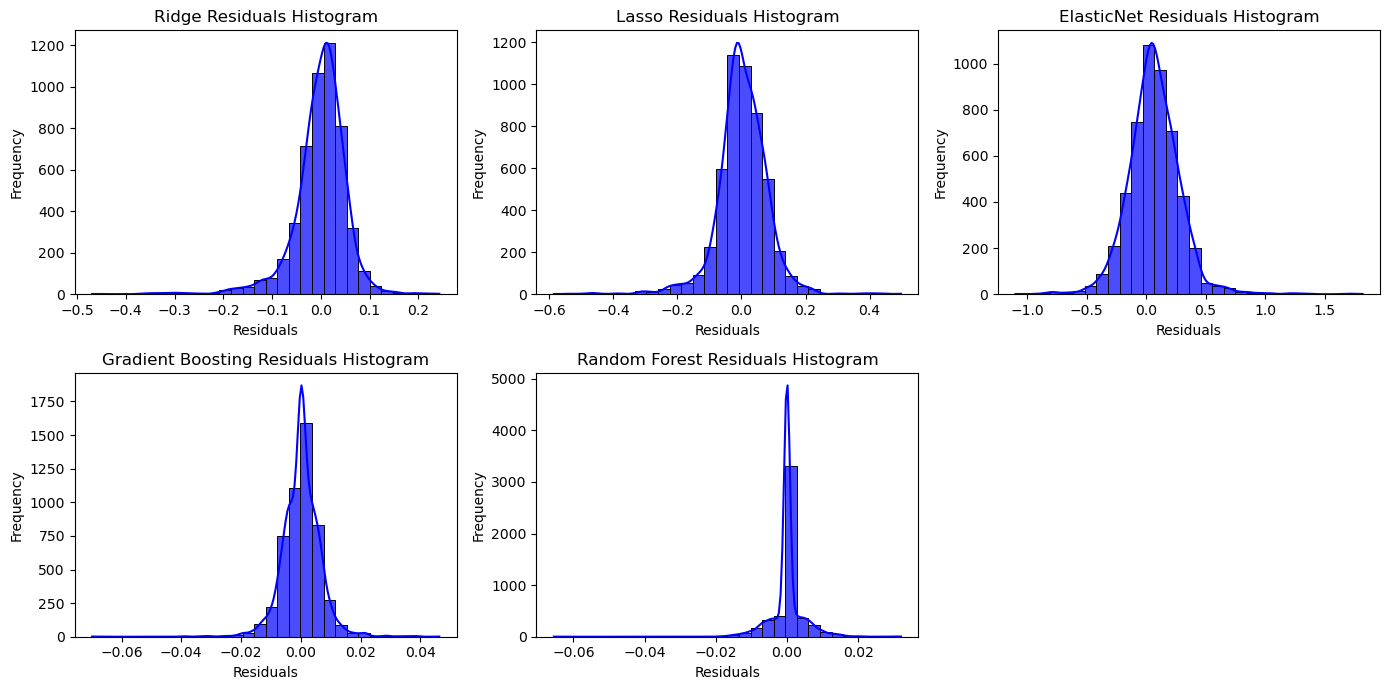

In [159]:
def plot_residuals(models, X_test, y_test):
    plt.figure(figsize=(14, 7))
    
    for i, (name, model) in enumerate(models.items()):
        y_test_pred = model.predict(X_test)
        residuals = y_test - y_test_pred
        
        plt.subplot(2, 3, i + 1)
        sns.histplot(
            residuals,
            bins=30,
            kde=True,
            color='blue',  # Color for the histogram bars
            edgecolor='black',  # Edge color for the histogram bars
            alpha=0.7
        )
        plt.title(f'{name} Residuals Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot residuals
plot_residuals(models, X_test0, y_test0)

Although, for the most part it appears that the residuals are normally distributed, the histograms might mask issues with tails or outliers because it aggregates data into bins, potentially smoothing out extreme values. 

We can explore this further with a QQ plot, which shows these extreme values more explicitly.

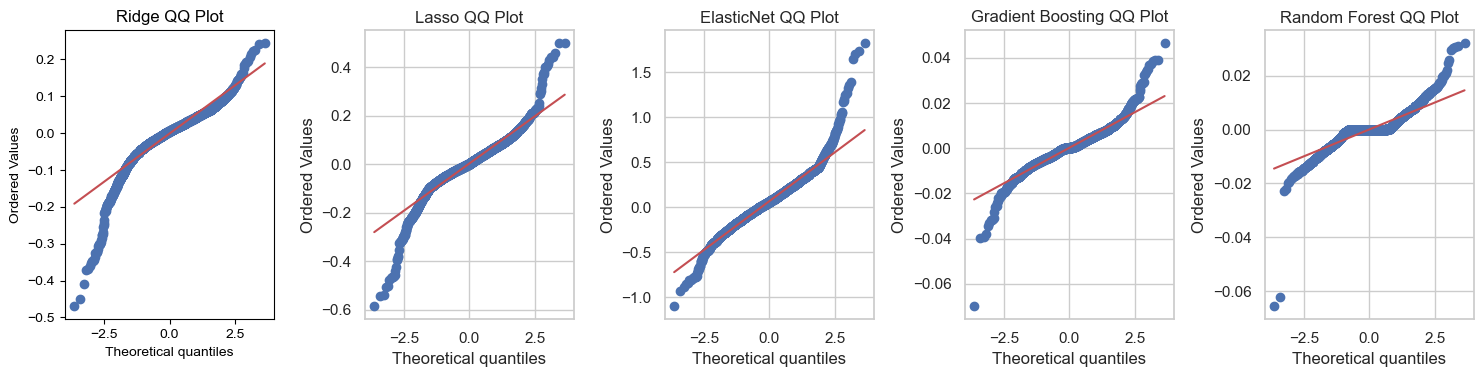

In [161]:
import scipy.stats as stats

def plot_qq_plots(models, X_test, y_test):
    plt.figure(figsize=(18, 7))
    
    for i, (name, model) in enumerate(models.items()):
        y_test_pred = model.predict(X_test)
        residuals = y_test - y_test_pred
        
        # QQ Plot
        plt.subplot(2, 6, i + 1)
        sns.set(style="whitegrid")  # Set Seaborn style
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f'{name} QQ Plot')

    plt.tight_layout()
    plt.show()

# Call the function to plot QQ plots
plot_qq_plots(models, X_test0, y_test0)

The QQ-Plots suggest that the residuals have heavier tails than a normal distribution. This means there are more extreme values than would be expected in a normal distribution. The models might not be capturing the extreme values or outliers effectively.

### Plotting the Actuals vs Predictions for the models

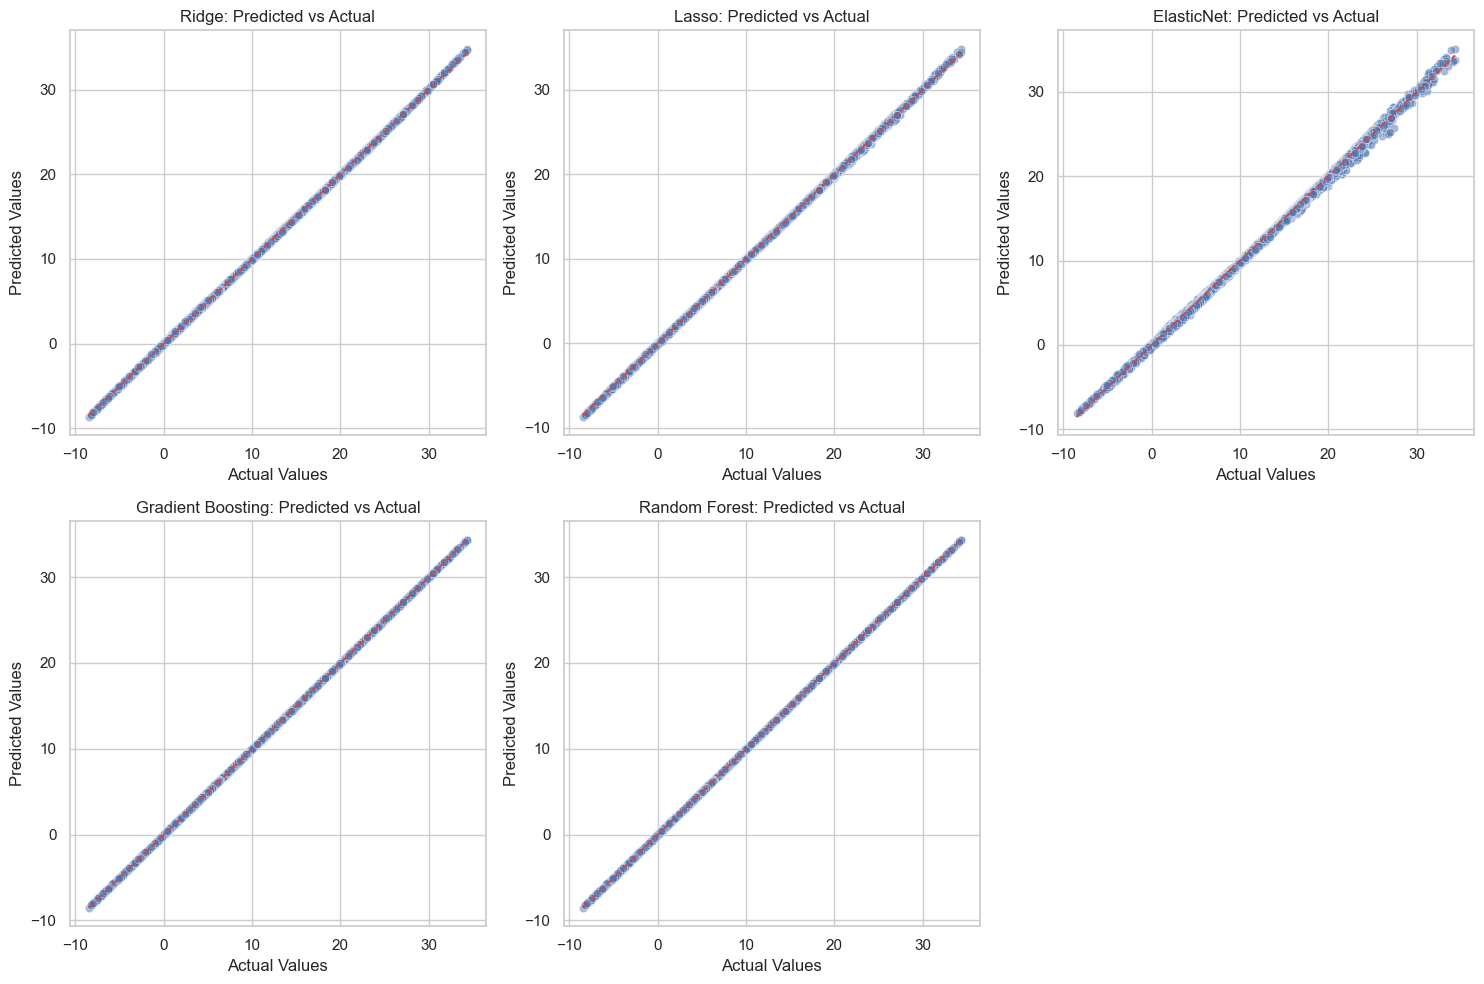

In [163]:
def plot_predictions_vs_actuals(models, X_test, y_test):
    plt.figure(figsize=(15, 10))
    
    for i, (name, model) in enumerate(models.items(), 1):
        y_pred = model.predict(X_test)
        
        # Scatter plot of actual vs. predicted values
        plt.subplot(2, 3, i)
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{name}: Predicted vs Actual')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the Function
plot_predictions_vs_actuals(models, X_test0, y_test0)

In [165]:
def plot_predictions_vs_actuals(model, X, y, start, end):
    # Predict using the model
    preds = model.predict(X)
    
    # Create a DataFrame with predictions and actual values
    df = pd.DataFrame(data={'Predictions': preds, 'Actuals': y}, index=X.index)
    
    # Slice the DataFrame for the desired range
    df_slice = df[start:end]
    
    # Plotting
    plt.figure(figsize=(20, 5))
    plt.plot(df_slice.index, df_slice['Predictions'], label='Predictions', color='red')
    plt.plot(df_slice.index, df_slice['Actuals'], label='Actuals', color='blue')
    plt.title('Predictions vs Actuals')
    plt.ylabel('T (degC)')
    plt.xlabel('Date Time')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show();

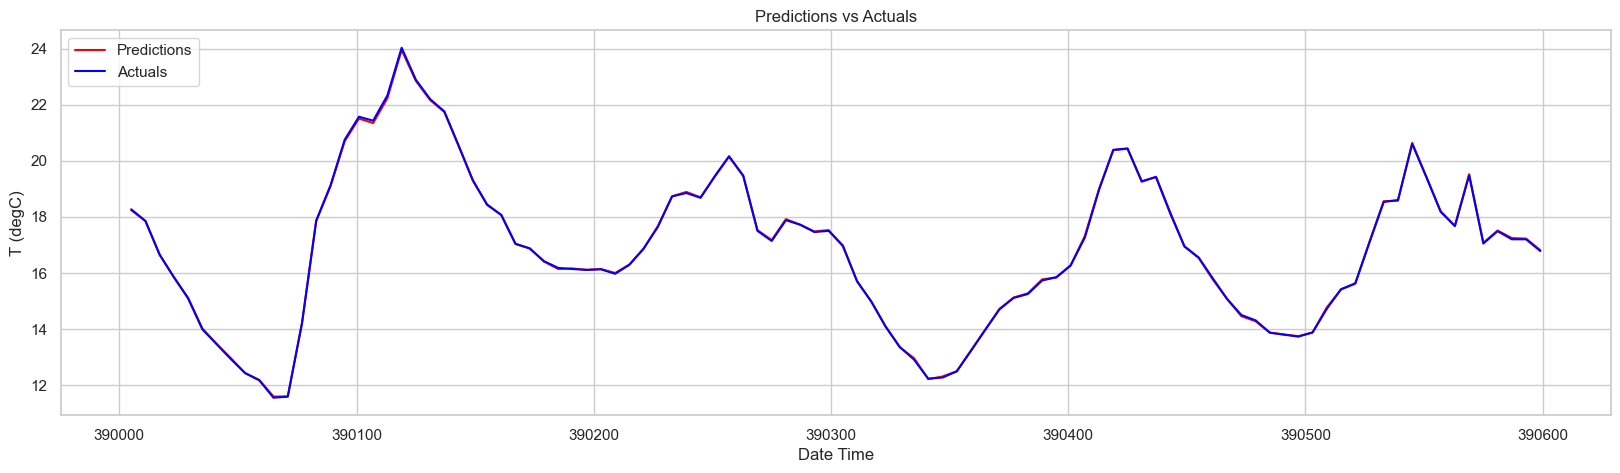

In [167]:
plot_predictions_vs_actuals(grid_search_ridge.best_estimator_, X_test0, y_test0, start= 0, end=100)

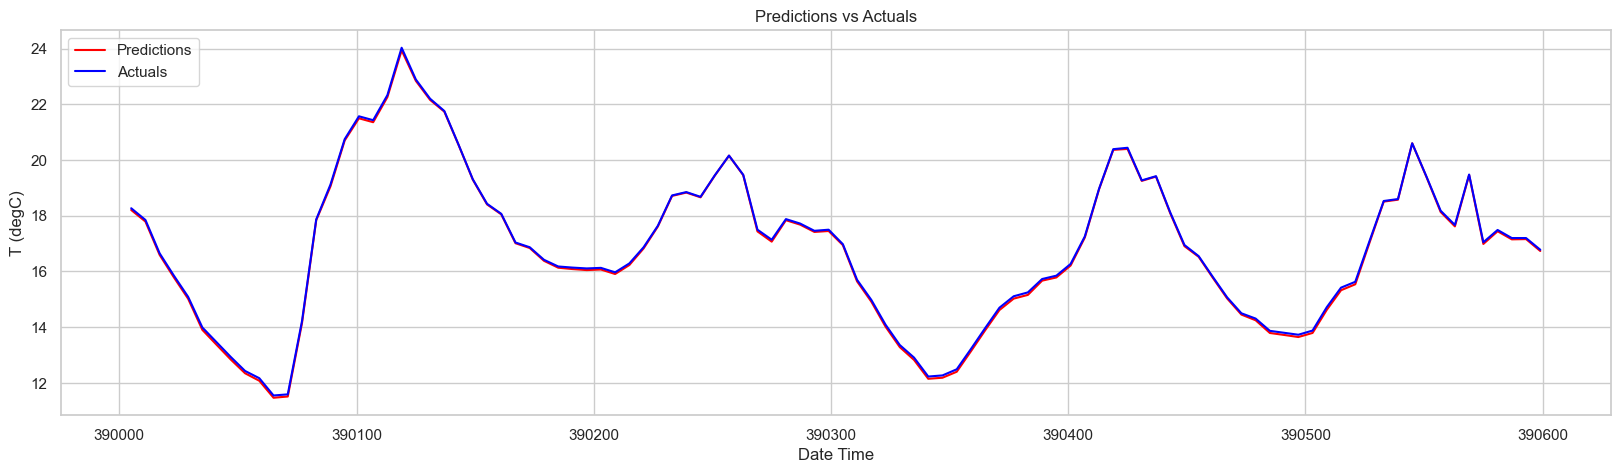

In [169]:
plot_predictions_vs_actuals(grid_search_lasso.best_estimator_, X_test0, y_test0, start= 0, end=100)

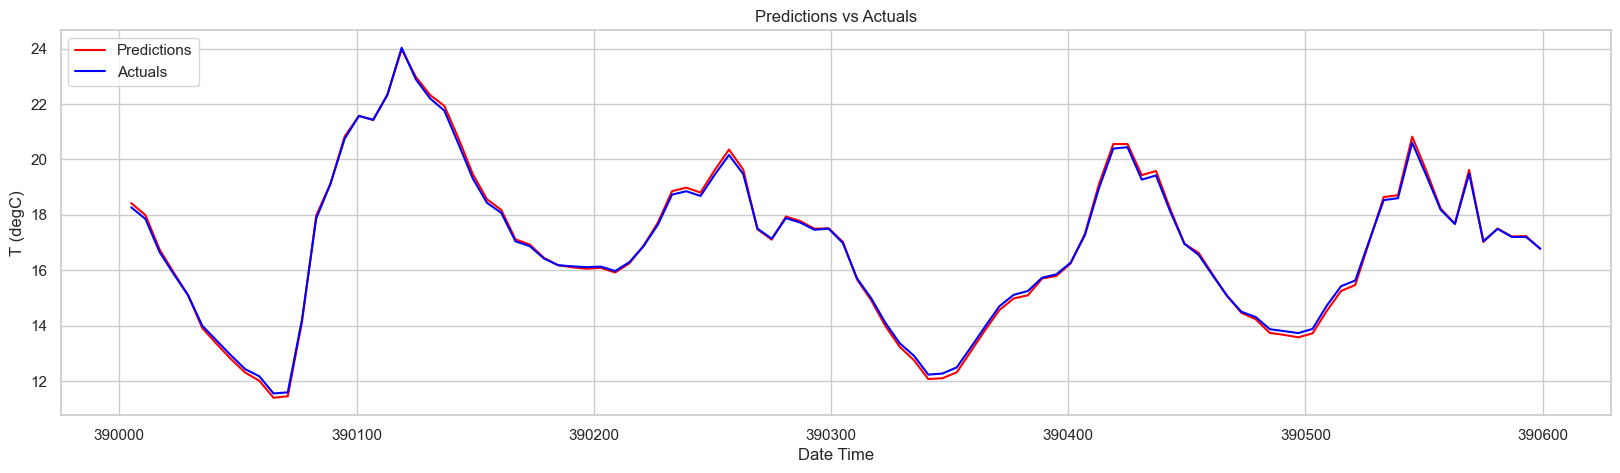

In [171]:
plot_predictions_vs_actuals(grid_search_en.best_estimator_, X_test0, y_test0, start= 0, end=100)

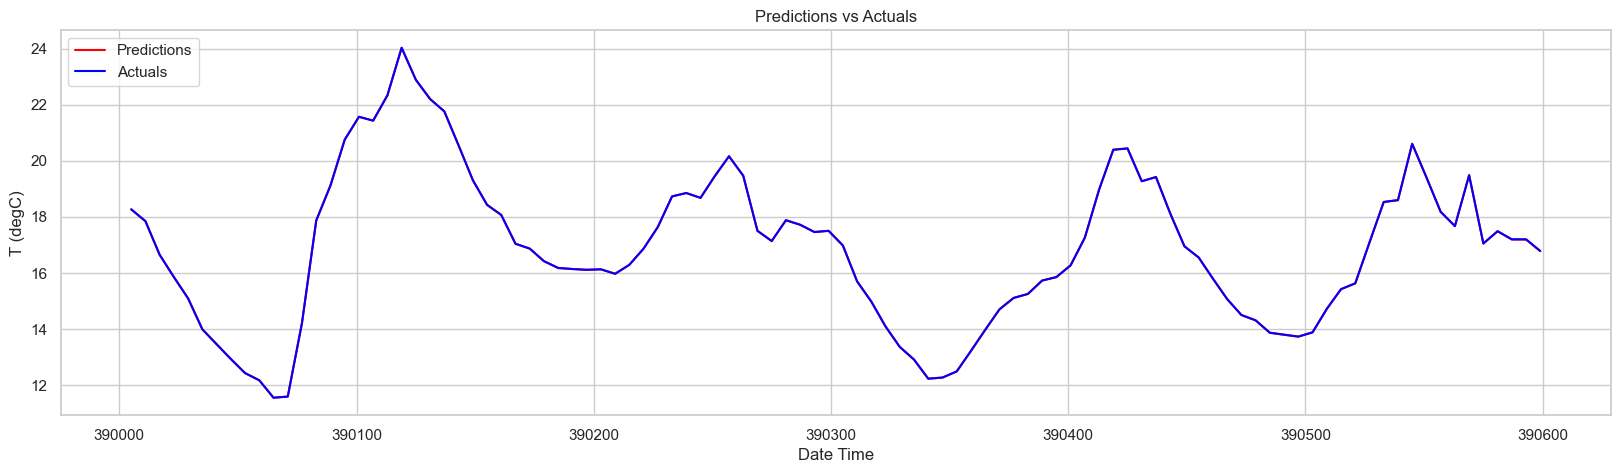

In [173]:
plot_predictions_vs_actuals(grid_search_gb.best_estimator_, X_test0, y_test0, start= 0, end=100)

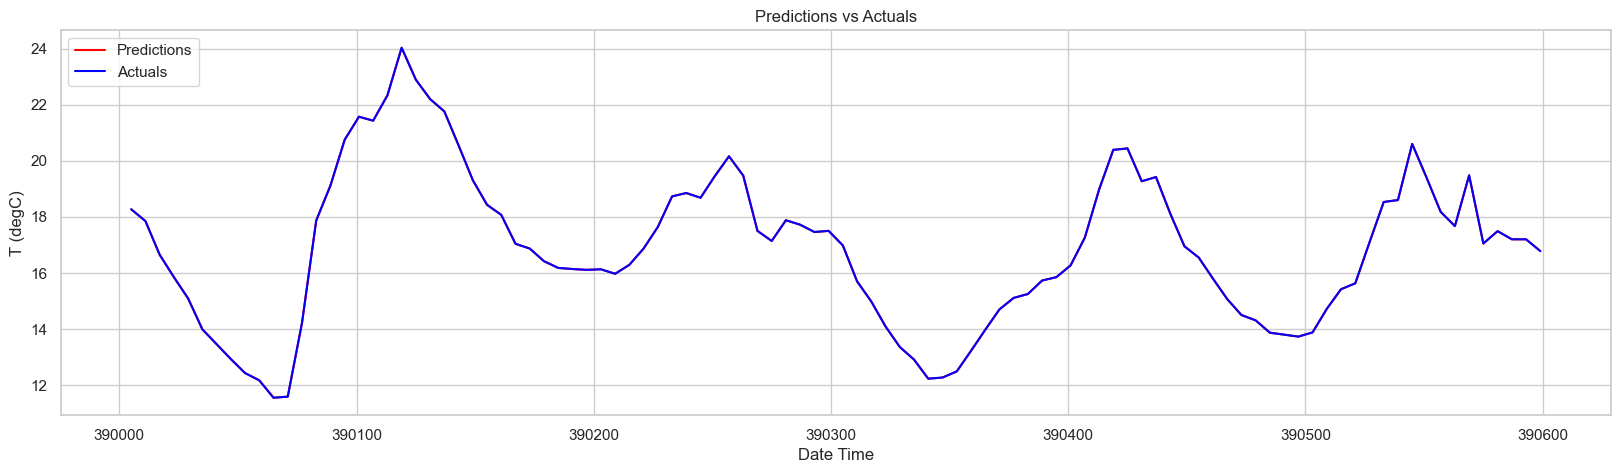

In [175]:
plot_predictions_vs_actuals(grid_search_rf.best_estimator_, X_test0, y_test0, start= 0, end=100)

In [177]:
test_results_df = results_df[results_df['Dataset'] == 'Testing'].reset_index(drop =  True)
test_results_df

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,Ridge,Testing,0.003077,0.055474,0.037851,0.999956,0.999956
1,Lasso,Testing,0.006557,0.080977,0.056681,0.999906,0.999905
2,ElasticNet,Testing,0.053665,0.231658,0.170228,0.999229,0.999226
3,Gradient Boosting,Testing,0.000042,0.006488,0.004521,0.999999,0.999999
4,Random Forest,Testing,0.000021,0.004560,0.002295,1.000000,1.000000


#### Summary

VPMax significantly influences both the Gradient Boosting (GB) and Random Forest (RF) models. To better understand its impact, we could implement feature permutation and column dropping techniques, which will help identify crucial features and improve model performance. 

Ridge and Lasso regressions show comparable metrics across training, validation, and testing, suggesting good generalization. 

In contrast, ElasticNet exhibits underfitting with higher errors and lower R² on training and validation datasets. 

GB and RF models demonstrate very low errors and high R², potentially indicating overfitting. 

Although residuals appear mostly normally distributed, QQ-Plots reveal heavier tails, suggesting the models may not effectively capture extreme values or outliers. 

While this analysis provides valuable insights, further exploration of residuals and model adjustments is beyond the current project's scope.

### Basis Analysis using Deep Learning Models (LSTM, Conv1D, GRU)

In [200]:
# Formatting the Date Time Index
df.index = pd.to_datetime(df['Date Time'], format = '%d.%m.%Y %H:%M:%S')
df[:25]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


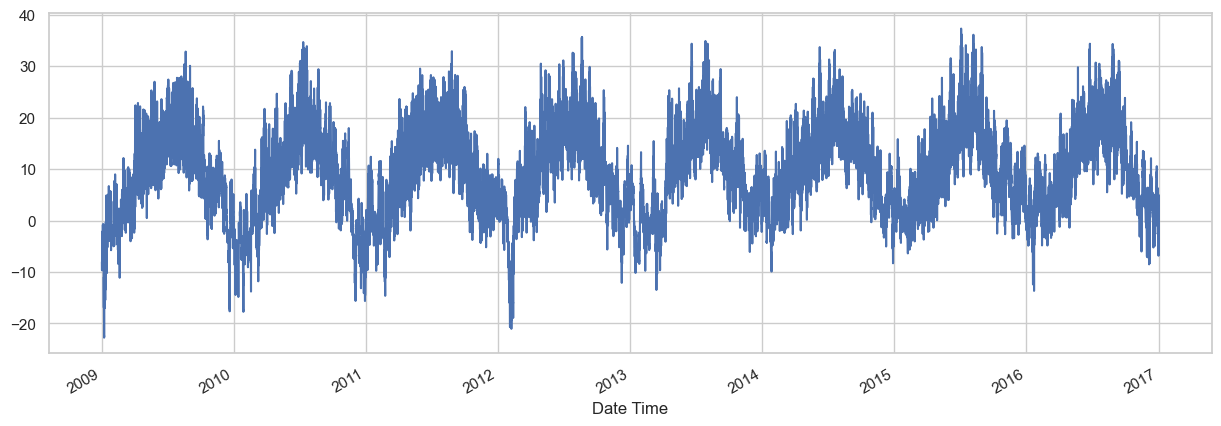

In [201]:
temp = df['T (degC)']
temp.plot(figsize = (15,5));

**BREAK**

The following functions are essential for the remainder of the model-building process.

In [205]:
def plot_predictions1(model, X, y, start = 0, end = 100):
    
    preds = model.predict(X).flatten()
    
    df = pd.DataFrame(data = {'Predictions': preds, 'Actuals': y})
    
    plt.figure(figsize=(20,5))
    plt.plot(df['Predictions'][start:end], label = 'Predictions', color='red')
    plt.plot(df['Actuals'][start:end], label = 'Actuals', color='blue')
    plt.title('Predictions vs Actuals')
    plt.ylabel('T (degC)')
    plt.xlabel('Date Time')
    plt.legend(loc = 'upper left')
    plt.show()
    
    k = X.shape[1] 
    n = len(X)  
    r2_value = r2(y, preds)  
    adj_r2 = 1 - (1 - r2_value) * (n - 1) / (n - k - 1) 

    metrics = {
        'MSE': mse(y, preds),
        'RMSE': float(np.sqrt(mse(y, preds))),
        'MAE': mae(y, preds),
        'R2': r2_value,
        'Adj_R2': adj_r2}
    
    return df, metrics
    
def model_result(model_name: str, dataset_name: str, metrics):  
        table = pd.DataFrame({
            'Model': [model_name],
            'Dataset': [dataset_name],
            'MSE': [metrics.get('MSE', 'N/A')],  
            'RMSE': [metrics.get('RMSE', 'N/A')],  
            'MAE': [metrics.get('MAE', 'N/A')],  
            'R2': [metrics.get('R2', 'N/A')],  
            'Adj_R2': [metrics.get('Adj_R2', 'N/A')]  
        })
        return table

**BREAK**

A way that we can do this would be for example by using hours 1 to 5 to predict hour 6 and then iterating. We can achieve this by creating a matrix for our dataset. 

Example:

    for i = [0], X = [[1], [2], [3], [4], [5]] and y = [6]
    for i = [1], X = [[2], [3], [4], [5], [6]] and y = [7]

**Window Size:** The window size determines how many previous time steps are used as input to predict the next value. For example, if window_size=5, the model will use the last 5 time steps' data to predict the value at the next time step.

In [209]:
random_seed = 42
np.random.seed(random_seed)

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [212]:
Window_Size = 5
X1,y1 = df_to_X_y(temp, Window_Size)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

In [213]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

#### LSTM Modelling 

In [215]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp1 = ModelCheckpoint(filepath+'\\model1.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model1.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [217]:
model_1 = model1.fit(X_train1, y_train1, validation_data = (X_val1, y_val1), epochs = 100, callbacks = [cp1, early_stopping])
model_1 

Epoch 1/100
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.4872 - root_mean_squared_error: 10.7159
Epoch 1: val_loss improved from inf to 5.26637, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model1.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 116.1817 - root_mean_squared_error: 10.7008 - val_loss: 5.2664 - val_root_mean_squared_error: 2.2949
Epoch 2/100
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 13.9031 - root_mean_squared_error: 3.7035
Epoch 2: val_loss improved from 5.26637 to 0.88661, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model1.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 13.8468 - root_mean_squared_error: 3.6956 - val_loss: 0.8866 - val_root_mean_squared_error: 0.9416
Epoch 3/100
1826/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 2.6343 - root_mean_squared_error: 1.6185
Epoc

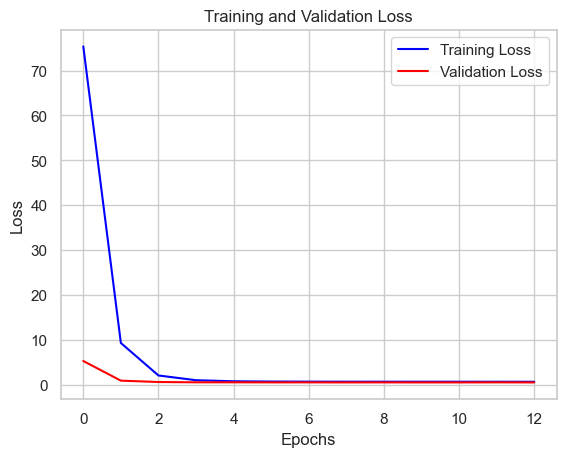

In [218]:
plt.plot(model_1.history['loss'], label='Training Loss', color = 'blue')
plt.plot(model_1.history['val_loss'], label='Validation Loss', color ='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [219]:
model1 = load_model(filepath+'\\model1.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step


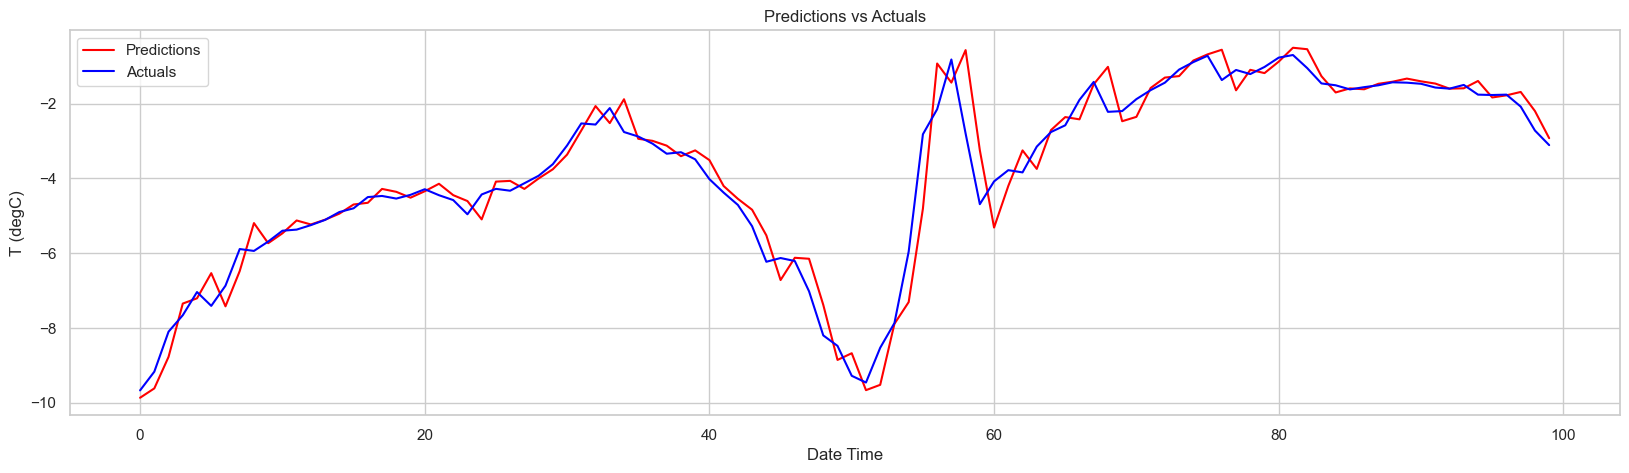

{'MSE': 0.641376382683155,
 'RMSE': 0.8008597771664868,
 'MAE': 0.5370086121778787,
 'R2': 0.991138258349354,
 'Adj_R2': 0.9911375197970279}

In [220]:
# Training Data
df_train, metrics_train = plot_predictions1(model1, X_train1, y_train1)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


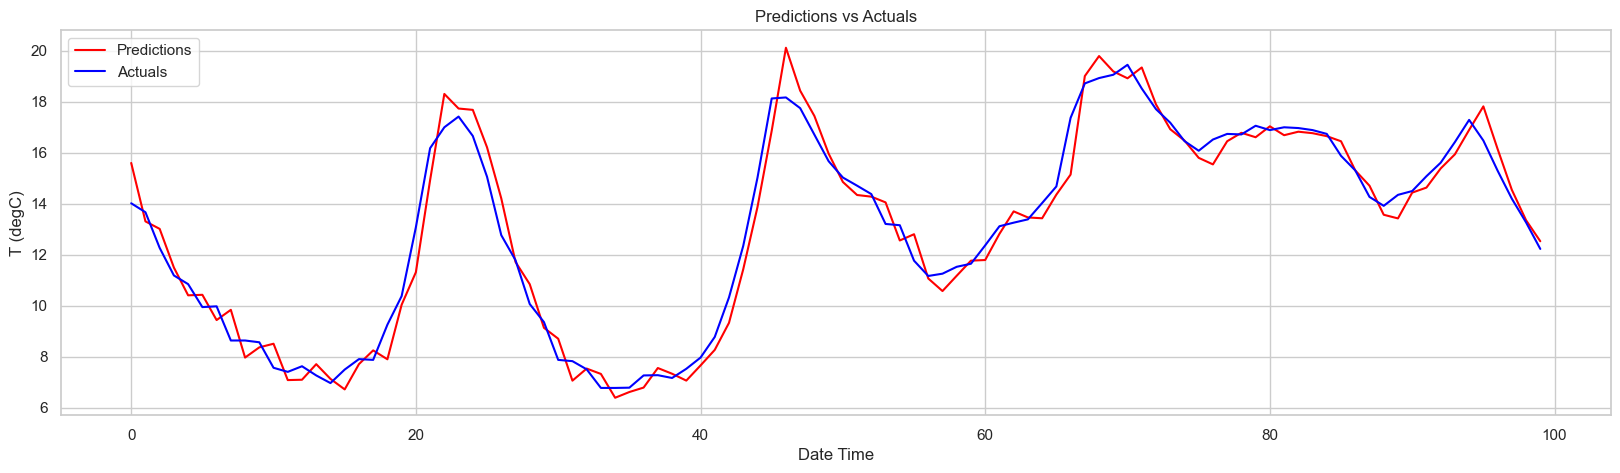

{'MSE': 0.486961833468604,
 'RMSE': 0.6978265067110908,
 'MAE': 0.4810977795778514,
 'R2': 0.9864055716358234,
 'Adj_R2': 0.9863919608745457}

In [223]:
# Validation Data
df_val, metrics_val = plot_predictions1(model1, X_val1, y_val1)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


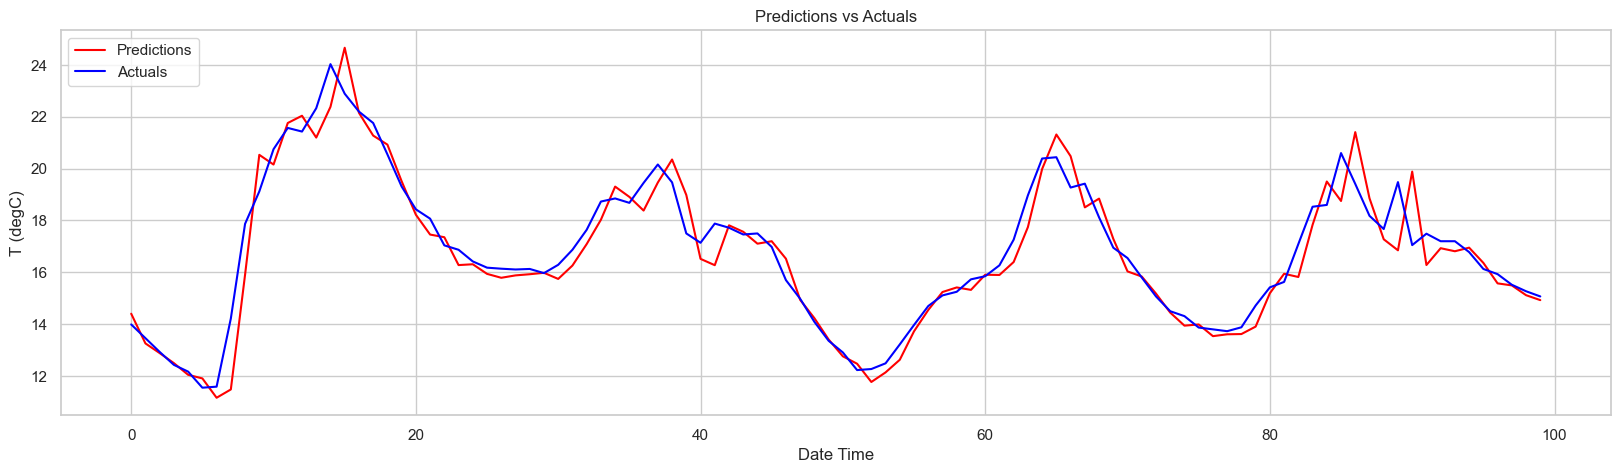

(      Predictions  Actuals
 0       14.403644    13.99
 1       13.258016    13.46
 2       12.884452    12.93
 3       12.497167    12.43
 4       12.046413    12.17
 ...           ...      ...
 5081    -0.863023    -0.98
 5082    -1.353840    -1.40
 5083    -1.723159    -2.75
 5084    -3.011540    -2.89
 5085    -3.062243    -3.93
 
 [5086 rows x 2 columns],
 {'MSE': 0.6192068633780803,
  'RMSE': 0.7868969839680924,
  'MAE': 0.5370913987499826,
  'R2': 0.9911059372379285,
  'Adj_R2': 0.991097183239147})

In [224]:
# Test Data
df_test, metrics_test = plot_predictions1(model1, X_test1, y_test1)
df_test, metrics_test

In [227]:
LSTM1_train = model_result('LSTM1', 'Training', metrics_train)
LSTM1_val = model_result('LSTM1', 'Validation', metrics_val)
LSTM1_test = model_result('LSTM1', 'Testing', metrics_test)
LSTM1_results = pd.concat([LSTM1_train, LSTM1_val, LSTM1_test], axis = 0)
LSTM1_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM1,Training,0.641376,0.800860,0.537009,0.991138,0.991138
0,LSTM1,Validation,0.486962,0.697827,0.481098,0.986406,0.986392
0,LSTM1,Testing,0.619207,0.786897,0.537091,0.991106,0.991097


#### Conv1D Modelling

In [229]:
model2 = Sequential()
model2.add(InputLayer((5,1)))
model2.add(Conv1D(64, kernel_size = 2))
model2.add(Flatten()) # Due to the nature of how the kernel_size works, we don't our model to be in a 2D form
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [230]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp2 = ModelCheckpoint(filepath+'\\model2.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model2.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [231]:
model_2 = model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2, early_stopping])
model_2

Epoch 1/100
1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 44.0474 - root_mean_squared_error: 6.1558
Epoch 1: val_loss improved from inf to 2.13091, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model2.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 924us/step - loss: 43.4805 - root_mean_squared_error: 6.1115 - val_loss: 2.1309 - val_root_mean_squared_error: 1.4598
Epoch 2/100
1835/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 2.2960 - root_mean_squared_error: 1.5080
Epoch 2: val_loss improved from 2.13091 to 0.83745, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model2.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - loss: 2.2834 - root_mean_squared_error: 1.5037 - val_loss: 0.8375 - val_root_mean_squared_error: 0.9151
Epoch 3/100
1830/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.0327 - root_mean_squared_error: 1.0160
Epoc

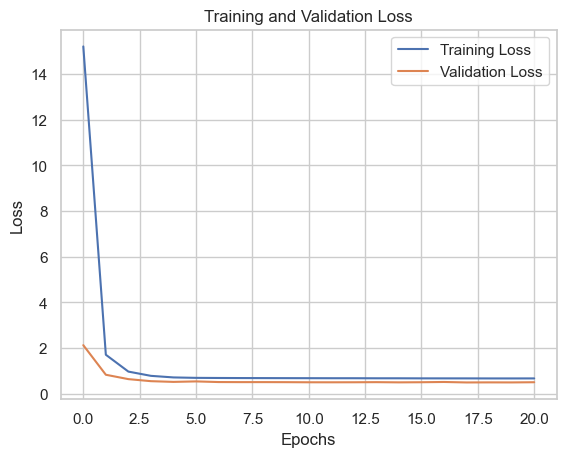

In [232]:
plt.plot(model_2.history['loss'], label='Training Loss')
plt.plot(model_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [233]:
model2 = load_model(filepath+'\\model2.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step


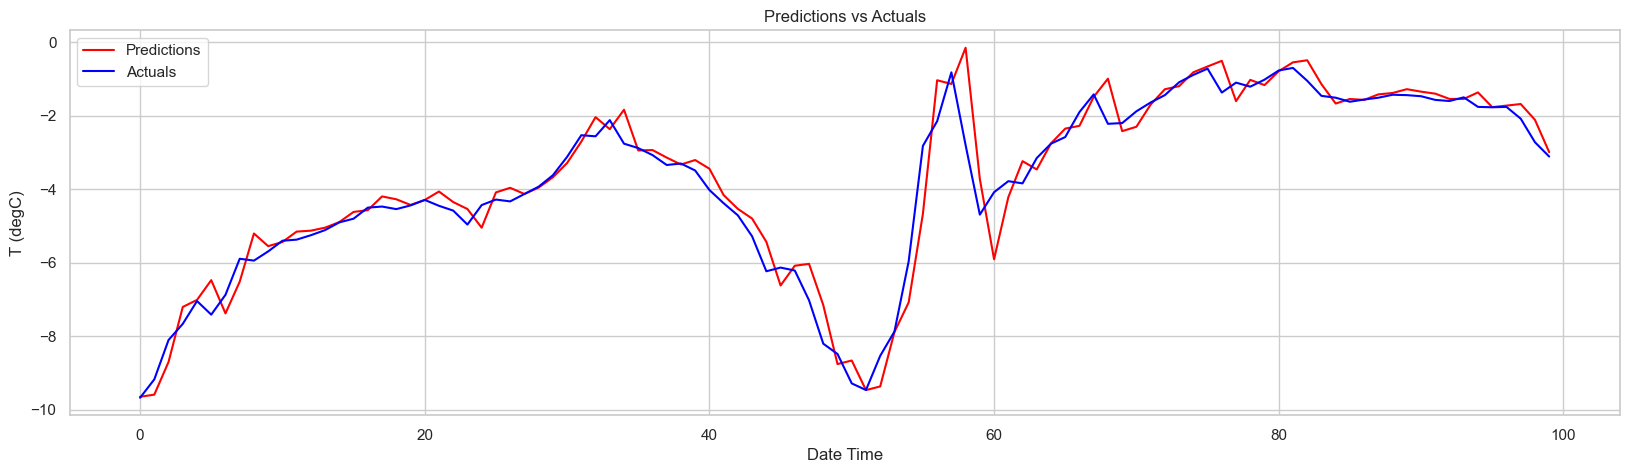

{'MSE': 0.6753854295952777,
 'RMSE': 0.8218183677646038,
 'MAE': 0.5509243894397343,
 'R2': 0.9906683636110115,
 'Adj_R2': 0.9906675858968743}

In [234]:
# Training Data
df_train, metrics_train = plot_predictions1(model2, X_train1, y_train1)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


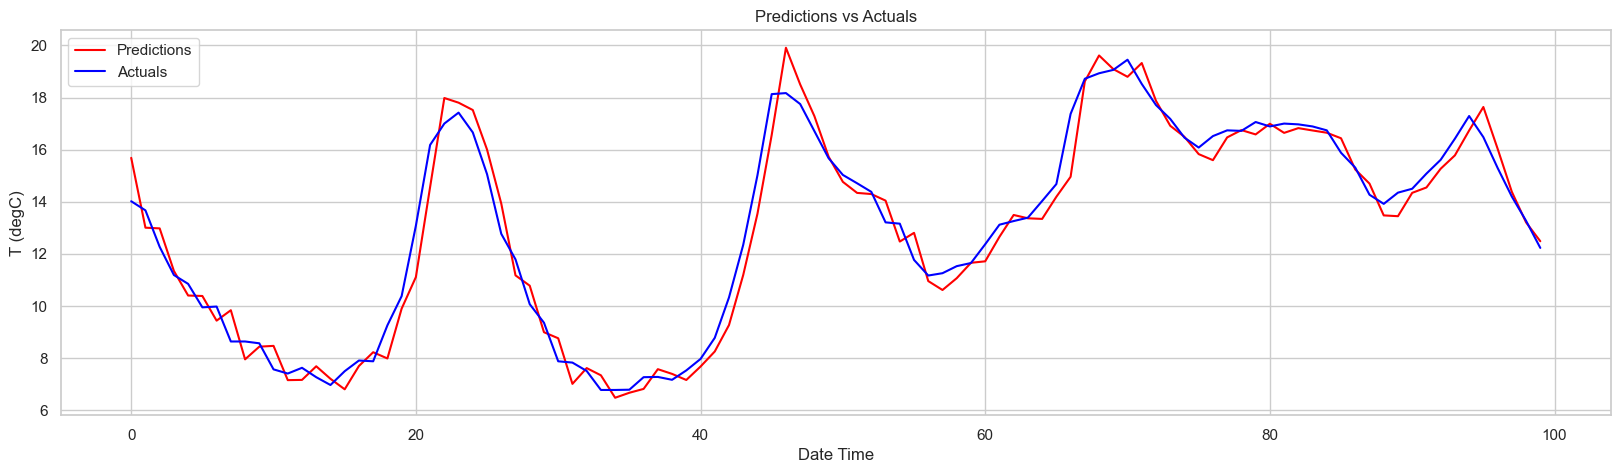

{'MSE': 0.5009406590370434,
 'RMSE': 0.7077716150263752,
 'MAE': 0.4888567387818247,
 'R2': 0.9860153272064975,
 'Adj_R2': 0.9860013257319346}

In [235]:
# Validation Data
df_val, metrics_val = plot_predictions1(model2, X_val1, y_val1)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


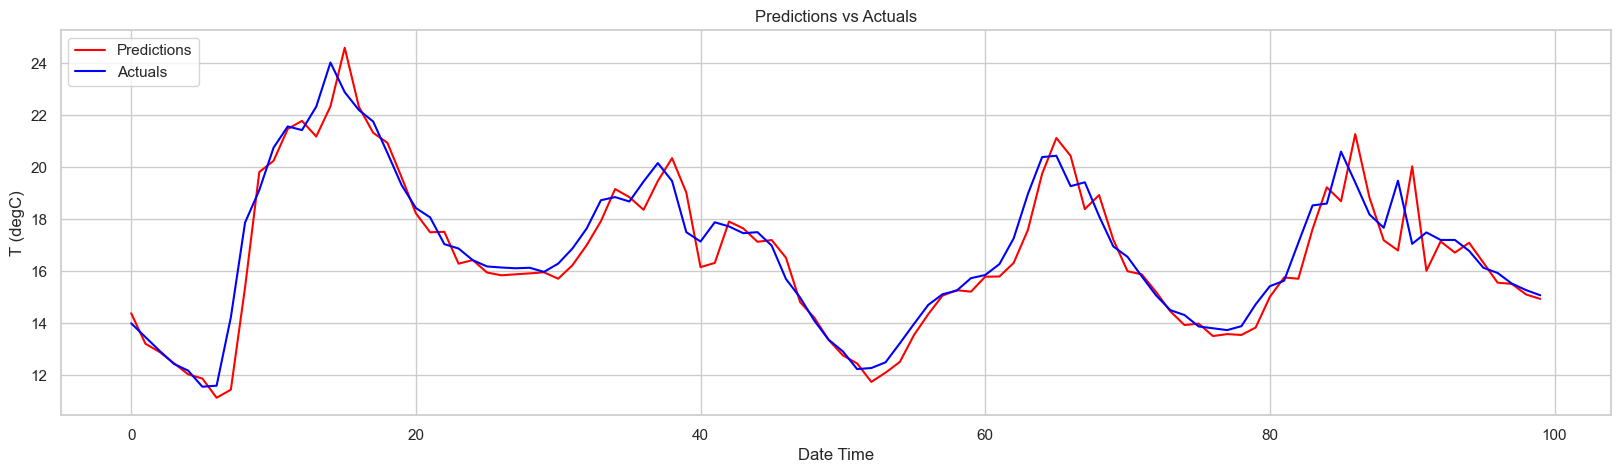

{'MSE': 0.6743721510756477,
 'RMSE': 0.82120165067762,
 'MAE': 0.5577330906163993,
 'R2': 0.9903135630572012,
 'Adj_R2': 0.9903040291625724}

In [236]:
# Test Data
df_test, metrics_test = plot_predictions1(model2, X_test1, y_test1)
metrics_test

In [237]:
Conv1D1_train = model_result('Conv1D1', 'Training', metrics_train)
Conv1D1_val = model_result('Conv1D1', 'Validation', metrics_val)
Conv1D1_test = model_result('Conv1D1', 'Testing', metrics_test)
Conv1D1_results = pd.concat([Conv1D1_train, Conv1D1_val, Conv1D1_test], axis = 0)
Conv1D1_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,Conv1D1,Training,0.675385,0.821818,0.550924,0.990668,0.990668
0,Conv1D1,Validation,0.500941,0.707772,0.488857,0.986015,0.986001
0,Conv1D1,Testing,0.674372,0.821202,0.557733,0.990314,0.990304


#### GRU Modelling

In [239]:
model3 = Sequential()
model3.add(InputLayer((5,1)))
model3.add(GRU(64))
model3.add(Flatten()) # Due to the nature of how the kernel_size works, we don't our model to be in a 2D form
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [240]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp3 = ModelCheckpoint(filepath+'\\model3.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model3.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [241]:
model_3 = model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp3, early_stopping])
model_3

Epoch 1/100
1829/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 49.4986 - root_mean_squared_error: 6.7552
Epoch 1: val_loss improved from inf to 0.89036, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model3.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 48.7608 - root_mean_squared_error: 6.6981 - val_loss: 0.8904 - val_root_mean_squared_error: 0.9436
Epoch 2/100
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 1.6201 - root_mean_squared_error: 1.2683
Epoch 2: val_loss improved from 0.89036 to 0.58377, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model3.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.6198 - root_mean_squared_error: 1.2681 - val_loss: 0.5838 - val_root_mean_squared_error: 0.7640
Epoch 3/100
1840/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8546 - root_mean_squared_error: 0.9242
Epoch 3: v

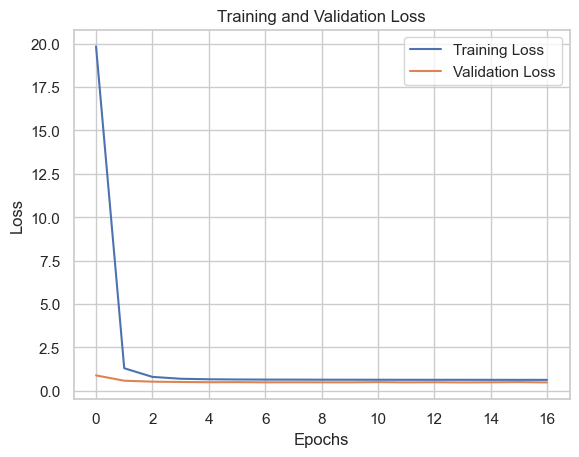

In [242]:
plt.plot(model_3.history['loss'], label='Training Loss')
plt.plot(model_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [243]:
model3 = load_model(filepath+'\\model3.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 747us/step


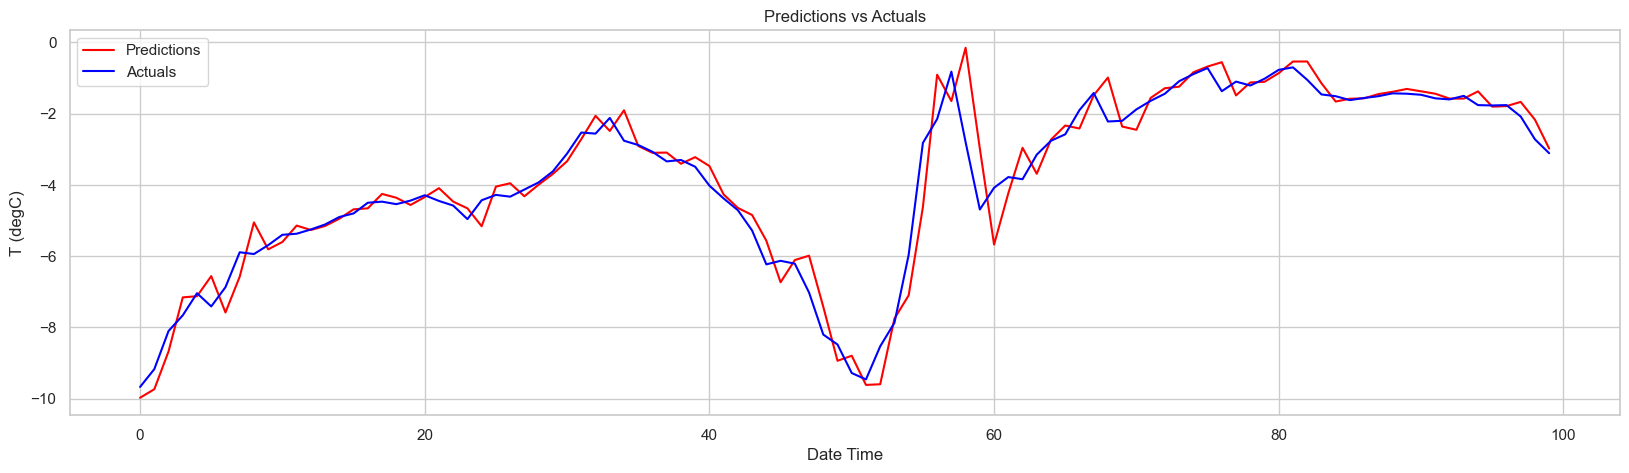

{'MSE': 0.6389573562446309,
 'RMSE': 0.7993480820297444,
 'MAE': 0.5391608184205839,
 'R2': 0.9911716814499281,
 'Adj_R2': 0.9911709456831389}

In [244]:
# Training Data
df_train, metrics_train = plot_predictions1(model3, X_train1, y_train1)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


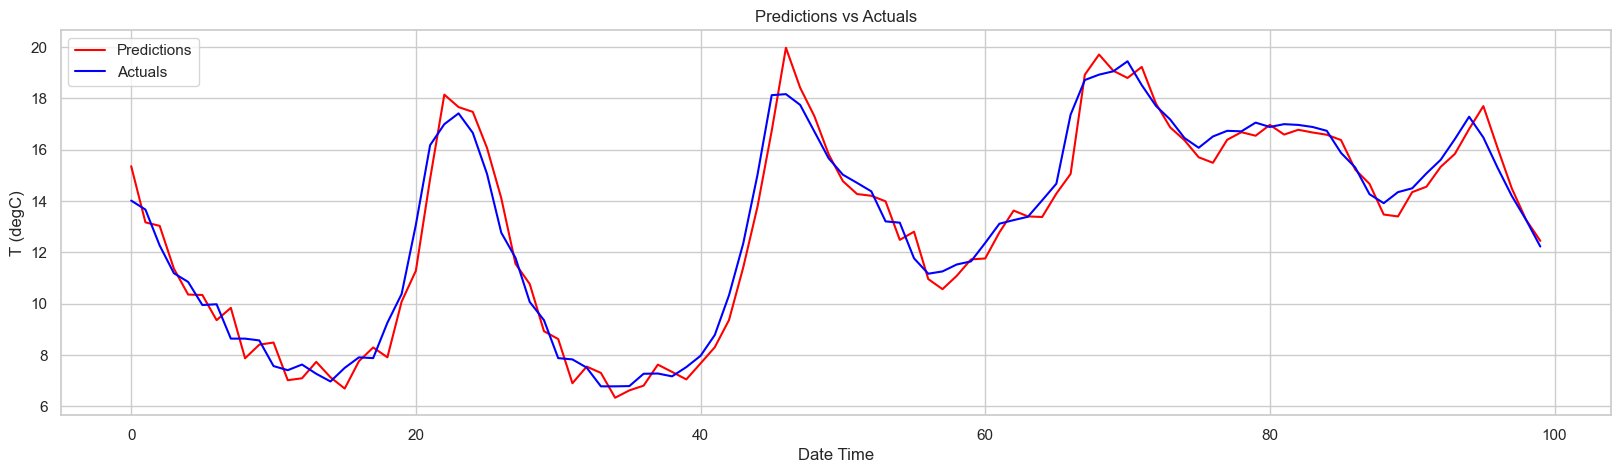

{'MSE': 0.4842111039206122,
 'RMSE': 0.6958527889723602,
 'MAE': 0.48139487453021845,
 'R2': 0.9864823632716752,
 'Adj_R2': 0.9864688293942939}

In [245]:
# Validation Data
df_val, metrics_val = plot_predictions1(model3, X_val1, y_val1)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


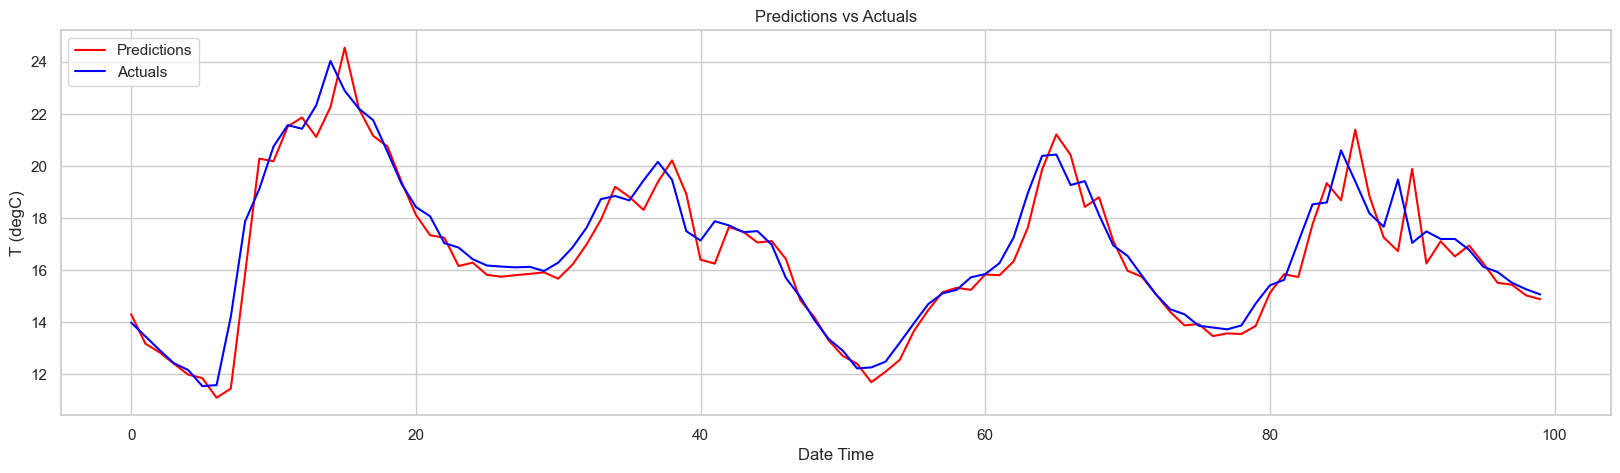

{'MSE': 0.6330047318638362,
 'RMSE': 0.7956159449532395,
 'MAE': 0.5473552242572873,
 'R2': 0.990907749660314,
 'Adj_R2': 0.9908988005950191}

In [246]:
# Test Data
df_test, metrics_test = plot_predictions1(model3, X_test1, y_test1)
metrics_test

In [247]:
GRU1_train = model_result('GRU1', 'Training', metrics_train)
GRU1_val = model_result('GRU1', 'Validation', metrics_val)
GRU1_test = model_result('GRU1', 'Testing', metrics_test)
GRU1_results = pd.concat([GRU1_train, GRU1_val, GRU1_test], axis = 0)
GRU1_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,GRU1,Training,0.638957,0.799348,0.539161,0.991172,0.991171
0,GRU1,Validation,0.484211,0.695853,0.481395,0.986482,0.986469
0,GRU1,Testing,0.633005,0.795616,0.547355,0.990908,0.990899


In [248]:
Stage_1_results = pd.concat([LSTM1_test, Conv1D1_test, GRU1_test], axis = 0).reset_index()
Stage_1_results

,index,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,0,LSTM1,Testing,0.619207,0.786897,0.537091,0.991106,0.991097
1,0,Conv1D1,Testing,0.674372,0.821202,0.557733,0.990314,0.990304
2,0,GRU1,Testing,0.633005,0.795616,0.547355,0.990908,0.990899


## Further Analysis with LSTM Models

For our upcoming experiments, we will apply a StandardScaler to scale the additional predictor variables that we plan to include in our models. By incorporating these extra variables, we aim to assess their impact on model performance and determine whether they improve the model’s ability to generalize to the data. We will evaluate how these additions influence the model’s performance and generalization capabilities.

A common technique used in time series analysis is splitting time into sine and cosine components. This can potentially benefit the impact of machine learning models when handling cyclic data. 

**Cyclic Nature of Time:** Time-based features like hours of the day, days of the week, or months of the year are cyclical. For example, the end of the day is followed by the beginning of a new day, making the time cyclical rather than linear. 

**Avoid Discontinuities:** When encoding cyclical features such as time directly as numbers, we can introduce discontinuities at the boundry (eg. 23:59 and 00:00). Using sine and consine functions would help model the cyclic nature without this discontinuity. 

**Better Representation:** Sine and cosine transformations map cyclical features onto a continuous circle, which can help machine learning models better capture patterns that repeat over time. 

**Feature Engineering:** These transformations can enhance the feature set and improve the model’s ability to learn from cyclic patterns. This can be particularly useful for models like neural networks or regression models that benefit from smooth and continuous input features. 

In [252]:
# Converting the index(timestamp) to Unix time(seconds since specific starting point)
temp_df = pd.DataFrame({'temp' : temp})
temp_df['secs'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,temp,secs
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [253]:
# Calculating variables to be used in further calculations to perform feature engineering
secs_in_day = 60*60*24
year = 365.2425*secs_in_day

temp_df['day_sin'] = np.sin(temp_df['secs'] * (2 * np.pi / secs_in_day))
temp_df['day_cos'] = np.cos(temp_df['secs'] * (2 * np.pi / secs_in_day))

temp_df['year_sin'] = np.sin(temp_df['secs'] * (2 * np.pi / year))
temp_df['year_cos'] = np.cos(temp_df['secs'] * (2 * np.pi / year))

# Since we have split secs into sin and cos variants we can drop the secs column
temp_df = temp_df.drop(['secs'], axis =1)

temp_df

,temp,day_sin,day_cos,year_sin,year_cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...
2016-12-31 19:10:00,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,-2.75,-0.675590,0.737277,0.008334,0.999965


Based on the adjustments that we have made above, we would need to adjust our function to define our X and y

Example:

**for i = [0]:** 

    X = [[t1, ds1, dc1, y1, y2], [t2, ds2, dc2, y2, y2], [t3, ds3, dc3, y3, y3], [t4, ds4, dc4, y4, y4], [t5, ds5, dc5, y5, y5]] 
    y = [t6]
    
**for i = [1]:** 

    X = [[t2, ds2, dc2, y2, y2], [t3, ds3, dc3, y3, y3], [t4, ds4, dc4, y4, y4], [t5, ds5, dc5, y5, y5], [t6, ds6, dc6, y6, y6]] 
    y = [t7]

In [255]:
random_seed = 42
np.random.seed(random_seed)

def df_to_X_y2(df, window_size=6): # Increased window size to 6
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]] # Changes made here - r is the whole row of data in temp_df
        X.append(row)
        label = df_as_np[i+window_size][0] # Changes made here - Translating into the variable of interest that we want 
        y.append(label)
    return np.array(X), np.array(y)

In [256]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((70085, 6, 5), (70085,))

In [257]:
X_train2, y_train2 = X2[:60000], y2[:60000]
X_val2, y_val2 = X2[60000:65000], y2[60000:65000]
X_test2, y_test2 = X2[65000:], y2[65000:]

X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

Our dataframe now has multiple values in different ranges, we will apply peprocessing to transform our temperature to fit in the range of the other values

In [259]:
temp_train_mean = np.mean(X_train2[:, :, 0])
temp_train_std = np.mean(X_train2[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - temp_train_mean) / temp_train_std
    return X

In [260]:
preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)

array([[[ 9.39352789e-01, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 8.94769966e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 7.67390473e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 6.82470810e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.01797131e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 4.85032595e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 8.94769966e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 7.67390473e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 6.82470810e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.01797131e-01, -2.58819045e-01,  9.65925826e-01,
  

In [261]:
model4 = Sequential()
model4.add(InputLayer((6,5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [262]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp4 = ModelCheckpoint(filepath+'\\model4.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model4.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [263]:
model_4 = model4.fit(X_train2, y_train2, validation_data = (X_val2, y_val2), epochs = 100, callbacks = [cp4, early_stopping])
model_4 

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92.9932 - root_mean_squared_error: 9.4426
Epoch 1: val_loss improved from inf to 4.04419, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model4.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 92.9686 - root_mean_squared_error: 9.4412 - val_loss: 4.0442 - val_root_mean_squared_error: 2.0110
Epoch 2/100
1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2637 - root_mean_squared_error: 2.4951
Epoch 2: val_loss improved from 4.04419 to 1.73864, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model4.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.2583 - root_mean_squared_error: 2.4940 - val_loss: 1.7386 - val_root_mean_squared_error: 1.3186
Epoch 3/100
1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2590 - root_mean_squared_error: 1.5007
Epoch 3: val_l

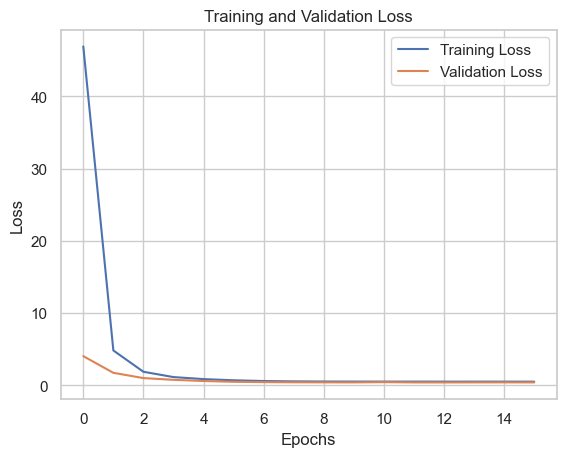

In [264]:
plt.plot(model_4.history['loss'], label='Training Loss')
plt.plot(model_4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [265]:
model4 = load_model(filepath+'\\model4.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step


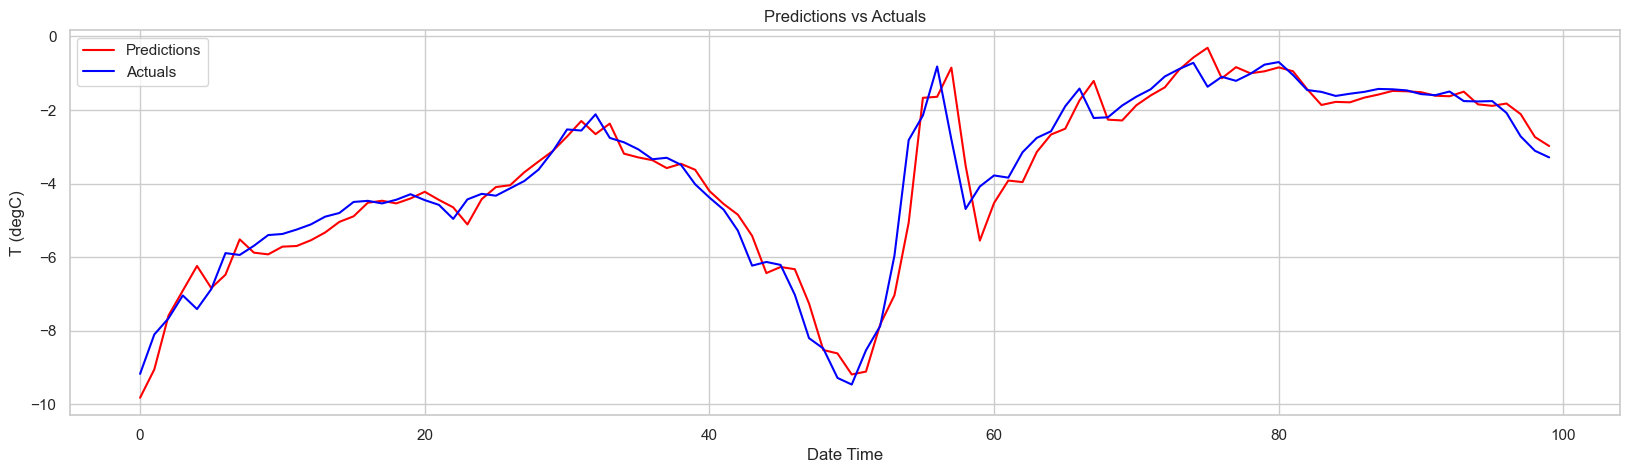

{'MSE': 0.5125882091484916,
 'RMSE': 0.7159526584547973,
 'MAE': 0.49236803136951235,
 'R2': 0.9929171332291172,
 'Adj_R2': 0.992916424859797}

In [266]:
df_train, metrics_train = plot_predictions1(model4, X_train2, y_train2)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


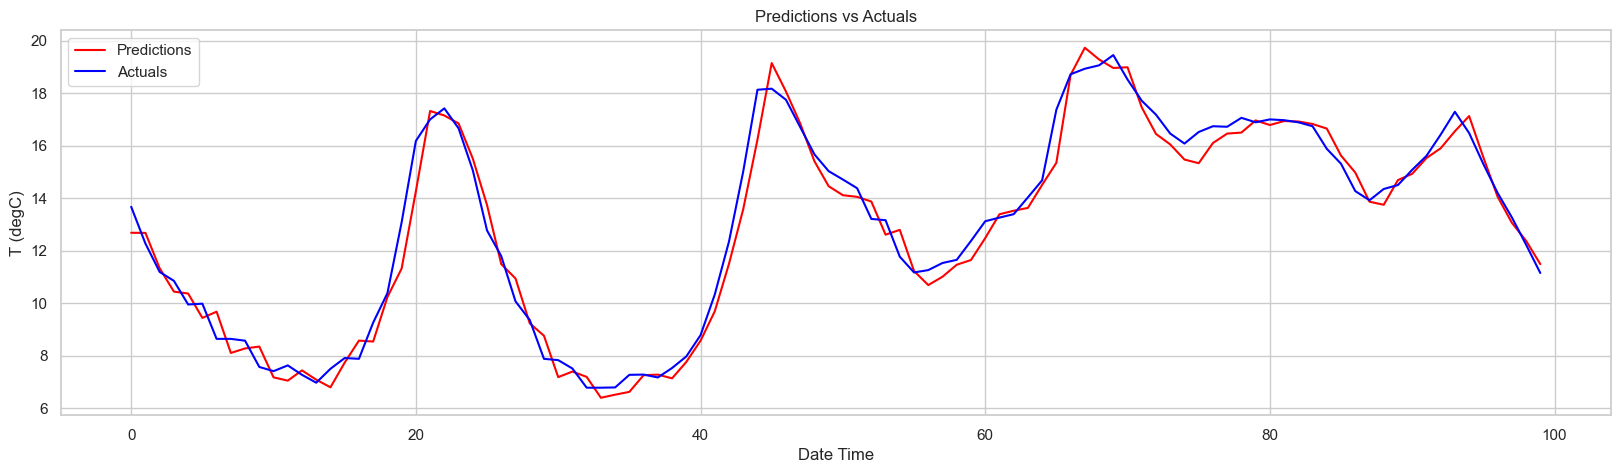

{'MSE': 0.4061227071955174,
 'RMSE': 0.6372775746843109,
 'MAE': 0.4501224478915334,
 'R2': 0.9886623150018642,
 'Adj_R2': 0.988648690705852}

In [267]:
df_val, metrics_val = plot_predictions1(model4, X_val2, y_val2)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step


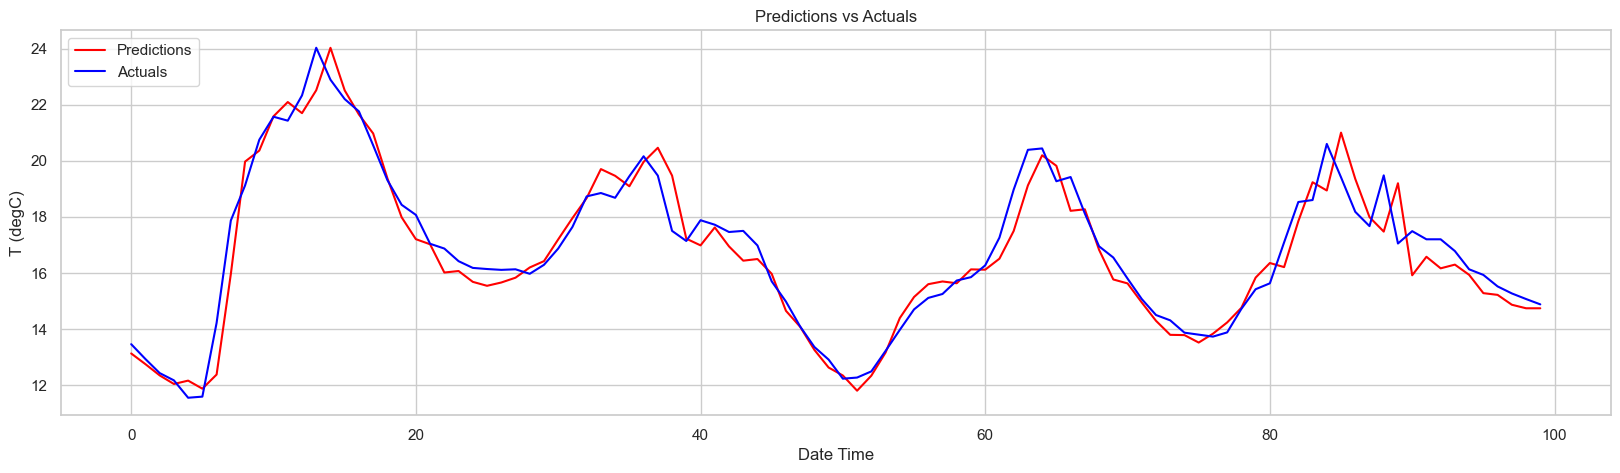

{'MSE': 0.4806723849484765,
 'RMSE': 0.6933054052497186,
 'MAE': 0.48143420604981974,
 'R2': 0.9930971202264754,
 'Adj_R2': 0.9930889640077591}

In [268]:
df_test, metrics_test = plot_predictions1(model4, X_test2, y_test2)
metrics_test

In [269]:
LSTM2_train = model_result('LSTM2', 'Training', metrics_train)
LSTM2_val = model_result('LSTM2', 'Validation', metrics_val)
LSTM2_test = model_result('LSTM2', 'Testing', metrics_test)
LSTM2_results = pd.concat([LSTM2_train, LSTM2_val, LSTM2_test], axis = 0)
LSTM2_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM2,Training,0.512588,0.715953,0.492368,0.992917,0.992916
0,LSTM2,Validation,0.406123,0.637278,0.450122,0.988662,0.988649
0,LSTM2,Testing,0.480672,0.693305,0.481434,0.993097,0.993089


We know that VPmax is strongly correlated with temeprature, however, we want to see whether or not it contributes meaningfully to the predictions. We can evaluate whether or not the model generalizes well to the data or not. 

When we have multiple variables in a time series, using all of them as both predictors and targets allows the model to learn the relationships between these variables over time.

For example, temp, VPmax (mbar), and p (mbar) might all influence each other. By using lagged values of all three as predictors, our model can capture the interdependencies and co-movements between these variables.

In this approach, the model predicts the future values of temp, VPmax (mbar), and p (mbar) based on their past values.


Some weather-related variables, such as temperature and vapor pressure, are often strongly correlated and interact with each other in complex ways. Using both as targets allows the model to simultaneously account for these interactions.

By leveraging all available data, the model can potentially achieve better predictive performance. For example, knowing the past temperature can help predict future vapor pressure, and vice versa.

When a model learns to predict multiple related targets simultaneously, it can sometimes generalize better because the tasks inform each other. This can reduce overfitting as the model is less likely to memorize noise specific to one target.

Predicting multiple targets adds complexity to the model. If the model shows signs of overfitting, we can use regularization techniques, like L2 regularization or dropout, to help manage this complexity.

### Adding only p (mbar) to the data as an additional predictor variable

In [272]:
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis =1)

In [273]:
p_temp_df

,p (mbar),temp,day_sin,day_cos,year_sin,year_cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...
2016-12-31 19:10:00,1002.18,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,1001.40,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,1001.19,-2.75,-0.675590,0.737277,0.008334,0.999965


In [274]:
random_seed = 42
np.random.seed(random_seed)

def df_to_X_y3(df, window_size=7): # Increased window size to 7
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]] # Changes made here - r is the whole row of data in temp_df
        X.append(row)
        label = df_as_np[i+window_size][1] # Changes made here - Translating into the variable of interest that we want 
        y.append(label)
    return np.array(X), np.array(y)

In [275]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape

((70084, 7, 6), (70084,))

In [276]:
X_train3, y_train3 = X3[:60000], y3[:60000]
X_val3, y_val3 = X3[60000:65000], y3[60000:65000]
X_test3, y_test3 = X3[65000:], y3[65000:]

X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((60000, 7, 6), (60000,), (5000, 7, 6), (5000,), (5084, 7, 6), (5084,))

In [277]:
p_train_mean = np.mean(X_train3[:, :, 0])
p_train_std = np.mean(X_train3[:, :, 0])

temp_train_mean2 = np.mean(X_train3[:, :, 1])
temp_train_std2 = np.mean(X_train3[:, :, 1])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - p_train_mean) / p_train_std
    X[:, :, 1] = (X[:, :, 1] - temp_train_mean2) / temp_train_std2
    return X

In [278]:
preprocess(X_train3)
preprocess(X_val3)
preprocess(X_test3)

array([[[-8.95182535e-03,  9.39313205e-01, -9.65925826e-01,
          2.58819045e-01,  5.22877889e-01, -8.52407598e-01],
        [-8.40580444e-03,  8.94731292e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-7.93056402e-03,  7.67354399e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        ...,
        [-7.34409711e-03,  6.01764437e-01, -2.58819045e-01,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01],
        [-6.91941418e-03,  4.85002284e-01, -7.16474371e-12,
          1.00000000e+00,  5.19819584e-01, -8.54276068e-01],
        [-6.68684972e-03,  4.28744156e-01,  2.58819045e-01,
          9.65925826e-01,  5.19207120e-01, -8.54648446e-01]],

       [[-8.40580444e-03,  8.94731292e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-7.93056402e-03,  7.67354399e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        [-7.62721

In [279]:
model5 = Sequential()
model5.add(InputLayer((7,6)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [280]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp5 = ModelCheckpoint(filepath+'\\model5.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model5.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [281]:
model_5 = model5.fit(X_train3, y_train3, validation_data = (X_val3, y_val3), epochs = 100, callbacks = [cp5, early_stopping])
model_5 

Epoch 1/100
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88.3102 - root_mean_squared_error: 9.1506
Epoch 1: val_loss improved from inf to 3.95571, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model5.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 87.5648 - root_mean_squared_error: 9.1075 - val_loss: 3.9557 - val_root_mean_squared_error: 1.9889
Epoch 2/100
1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5577 - root_mean_squared_error: 2.3508
Epoch 2: val_loss improved from 3.95571 to 1.62913, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model5.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.5482 - root_mean_squared_error: 2.3487 - val_loss: 1.6291 - val_root_mean_squared_error: 1.2764
Epoch 3/100
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1341 - root_mean_squared_error: 1.4592
Epoch 3: val_l

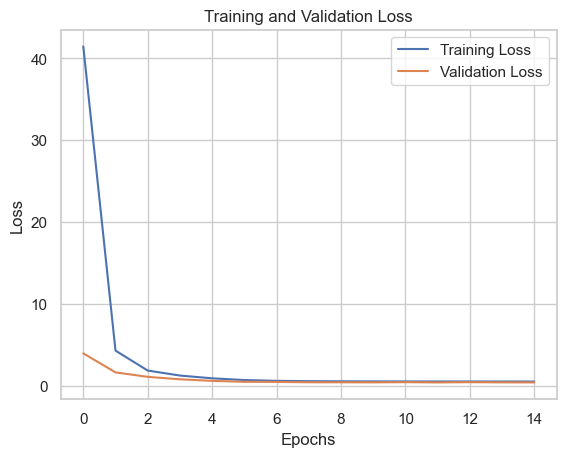

In [282]:
plt.plot(model_5.history['loss'], label='Training Loss')
plt.plot(model_5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [283]:
model5 = load_model(filepath+'\\model5.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step


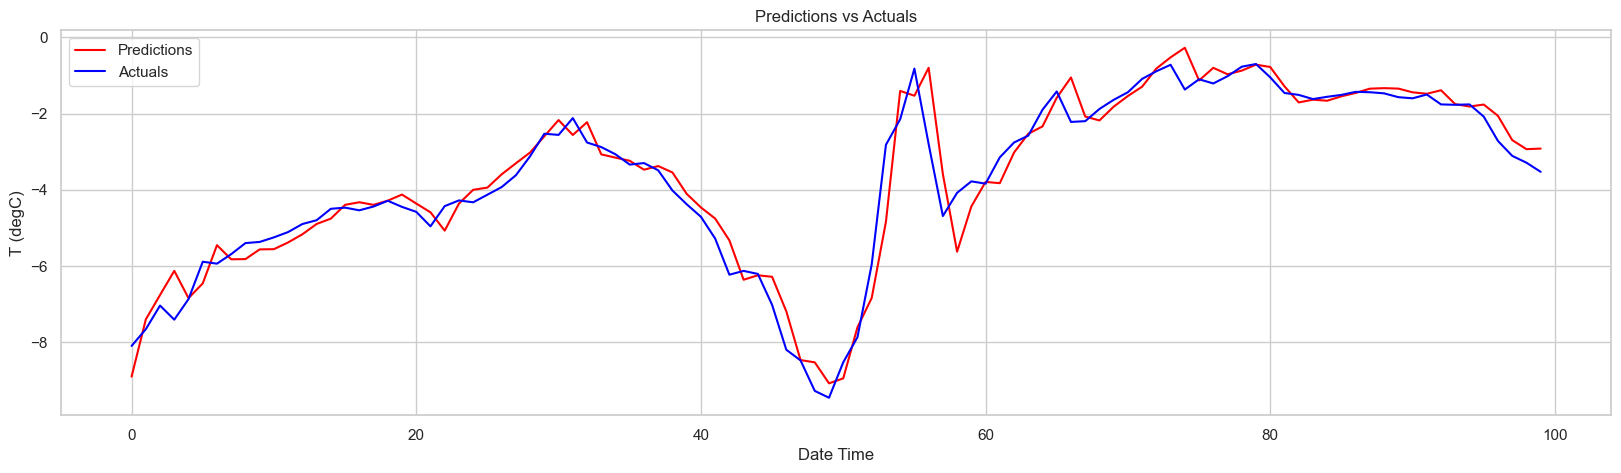

{'MSE': 0.512119511462813,
 'RMSE': 0.7156252591006085,
 'MAE': 0.48974368639787536,
 'R2': 0.9929230756585302,
 'Adj_R2': 0.9929222499072569}

In [284]:
df_train, metrics_train = plot_predictions1(model5, X_train3, y_train3)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


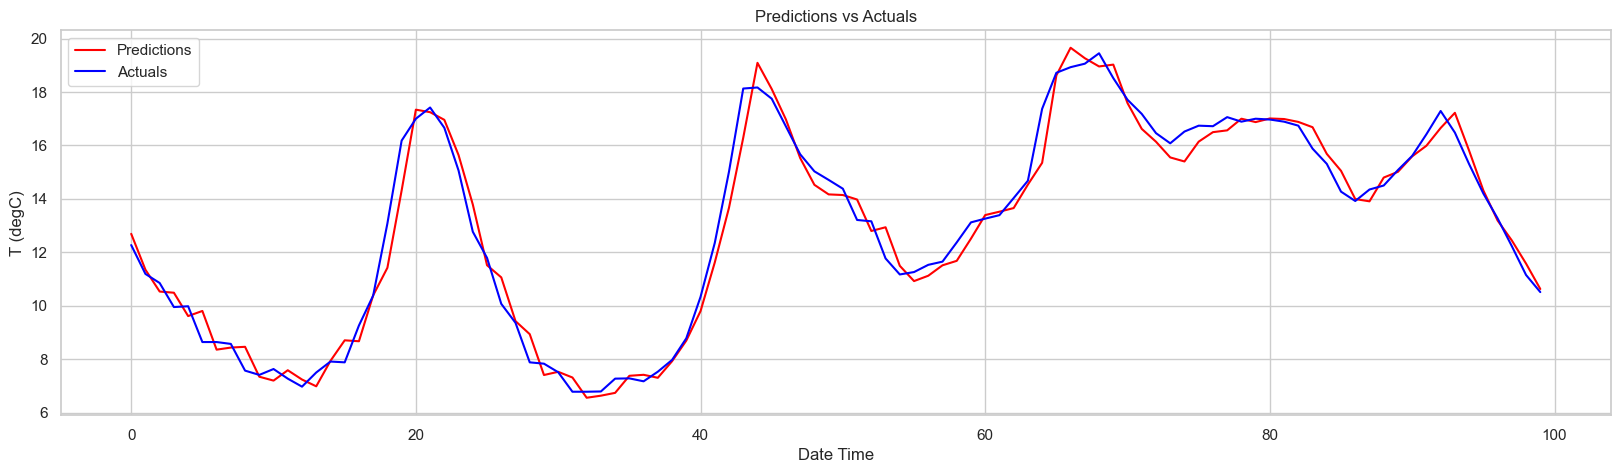

{'MSE': 0.39903289564325617,
 'RMSE': 0.6316905062158653,
 'MAE': 0.4416884996481538,
 'R2': 0.9888600567689113,
 'Adj_R2': 0.9888444358549254}

In [285]:
df_val, metrics_val = plot_predictions1(model5, X_val3, y_val3)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


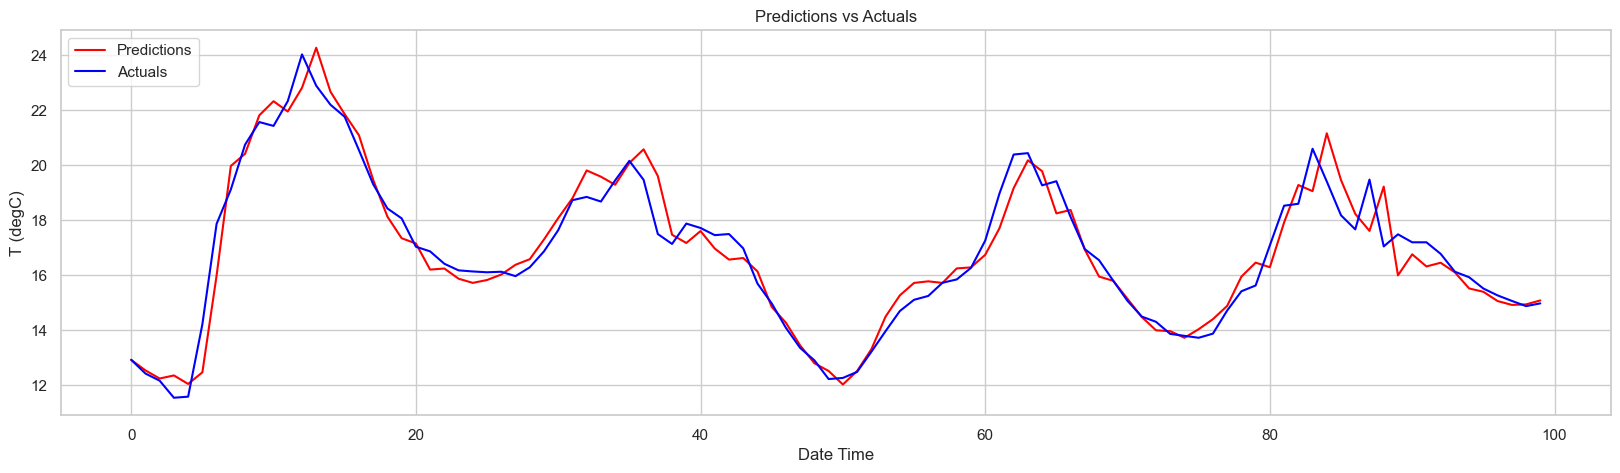

{'MSE': 0.4725022242036226,
 'RMSE': 0.6873879721115453,
 'MAE': 0.47369258579092405,
 'R2': 0.9932157736843812,
 'Adj_R2': 0.9932064179743321}

In [286]:
df_test, metrics_test = plot_predictions1(model5, X_test3, y_test3)
metrics_test

In [287]:
LSTM3_train = model_result('LSTM3', 'Training', metrics_train)
LSTM3_val = model_result('LSTM3', 'Validation', metrics_val)
LSTM3_test = model_result('LSTM3', 'Testing', metrics_test)
LSTM3_results = pd.concat([LSTM3_train, LSTM3_val, LSTM3_test], axis = 0)
LSTM3_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM3,Training,0.512120,0.715625,0.489744,0.992923,0.992922
0,LSTM3,Validation,0.399033,0.631691,0.441688,0.988860,0.988844
0,LSTM3,Testing,0.472502,0.687388,0.473693,0.993216,0.993206


### Adding only VPmax (mbar) to the data as an additional predictor variable

In [289]:
vpmax_temp_df = pd.concat([df['VPmax (mbar)'], temp_df], axis =1)
vpmax_temp_df

,VPmax (mbar),temp,day_sin,day_cos,year_sin,year_cos
Date Time,,,,,,
2009-01-01 01:00:00,3.33,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,3.12,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,3.13,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,3.07,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,2.94,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...
2016-12-31 19:10:00,5.69,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,5.51,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,4.99,-2.75,-0.675590,0.737277,0.008334,0.999965


In [290]:
random_seed = 42
np.random.seed(random_seed)

def df_to_X_y4(df, window_size=7): 
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][1]  
        y.append(label)
    return np.array(X), np.array(y)

In [291]:
X4, y4 = df_to_X_y4(vpmax_temp_df)
X4.shape, y4.shape

((70084, 7, 6), (70084,))

In [292]:
X_train4, y_train4 = X4[:60000], y4[:60000]
X_val4, y_val4 = X4[60000:65000], y4[60000:65000]
X_test4, y_test4 = X4[65000:], y4[65000:]

X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((60000, 7, 6), (60000,), (5000, 7, 6), (5000,), (5084, 7, 6), (5084,))

In [293]:
vpmax_train_mean = np.mean(X_train4[:, :, 0])
vpmax_train_std = np.mean(X_train4[:, :, 0])

temp_train_mean3 = np.mean(X_train4[:, :, 1])
temp_train_std3 = np.mean(X_train4[:, :, 1])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - vpmax_train_mean) / vpmax_train_std
    X[:, :, 1] = (X[:, :, 1] - temp_train_mean3) / temp_train_std3
    return X

#def preprocess_output(y):
#    y[:, 1] = (y[:, 1] - temp_train_mean) / temp_train_std
#    return y

In [294]:
preprocess(X_train4)
preprocess(X_val4)
preprocess(X_test4)

array([[[ 5.49061672e-01,  9.39313205e-01, -9.65925826e-01,
          2.58819045e-01,  5.22877889e-01, -8.52407598e-01],
        [ 5.08548885e-01,  8.94731292e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [ 3.98059464e-01,  7.67354399e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        ...,
        [ 2.65472160e-01,  6.01764437e-01, -2.58819045e-01,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01],
        [ 1.78553816e-01,  4.85002284e-01, -7.16474371e-12,
          1.00000000e+00,  5.19819584e-01, -8.54276068e-01],
        [ 1.38777625e-01,  4.28744156e-01,  2.58819045e-01,
          9.65925826e-01,  5.19207120e-01, -8.54648446e-01]],

       [[ 5.08548885e-01,  8.94731292e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [ 3.98059464e-01,  7.67354399e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        [ 3.28819

In [295]:
model6 = Sequential()
model6.add(InputLayer((7,6)))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [296]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp6 = ModelCheckpoint(filepath+'\\model6.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model6.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [297]:
model_6 = model6.fit(X_train4, y_train4, validation_data = (X_val4, y_val4), epochs = 100, callbacks = [cp6, early_stopping])
model_6 

Epoch 1/100
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.1237 - root_mean_squared_error: 8.1986
Epoch 1: val_loss improved from inf to 4.17645, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model6.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 71.6339 - root_mean_squared_error: 8.1677 - val_loss: 4.1765 - val_root_mean_squared_error: 2.0436
Epoch 2/100
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1379 - root_mean_squared_error: 2.2584
Epoch 2: val_loss improved from 4.17645 to 1.40935, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model6.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.1357 - root_mean_squared_error: 2.2579 - val_loss: 1.4093 - val_root_mean_squared_error: 1.1872
Epoch 3/100
1840/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4993 - root_mean_squared_error: 1.2236
Epoch 3: val_l

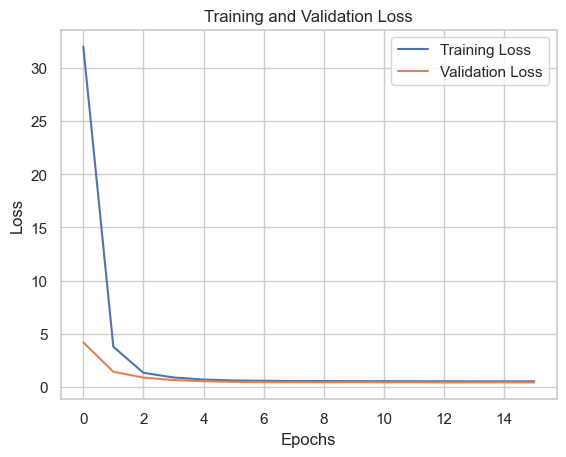

In [298]:
plt.plot(model_6.history['loss'], label='Training Loss')
plt.plot(model_6.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [299]:
model6 = load_model(filepath+'\\model6.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 757us/step


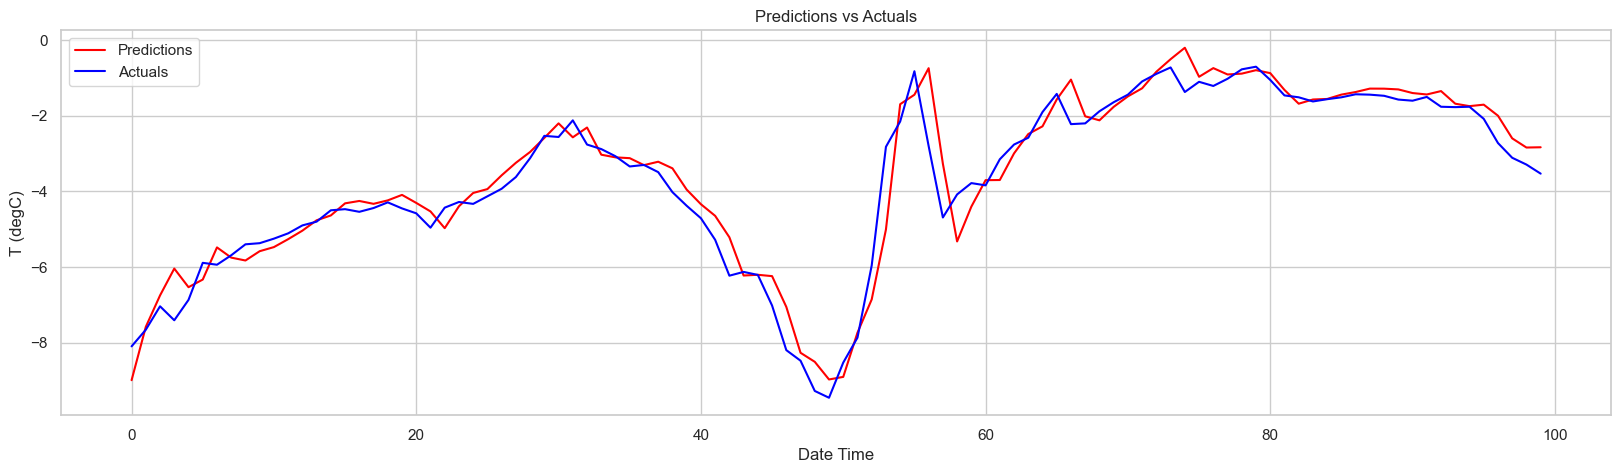

{'MSE': 0.5074847538524689,
 'RMSE': 0.7123796416605889,
 'MAE': 0.488227660837474,
 'R2': 0.9929871228744931,
 'Adj_R2': 0.9929863045963914}

In [300]:
df_train, metrics_train = plot_predictions1(model6, X_train4, y_train4)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


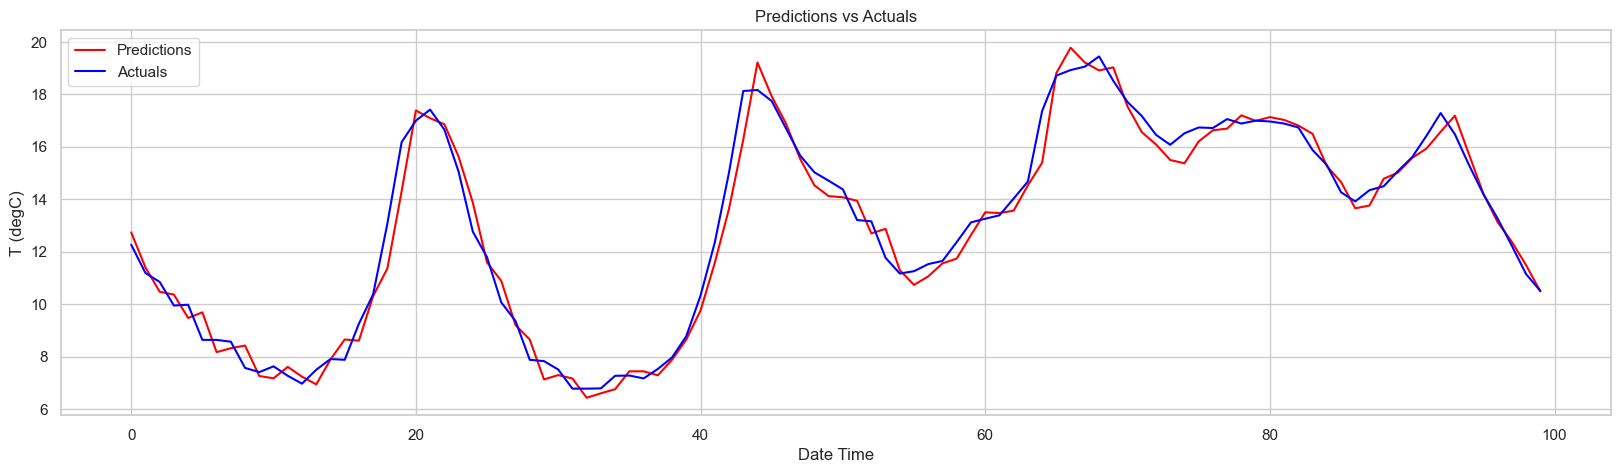

{'MSE': 0.40273556105849423,
 'RMSE': 0.634614497989523,
 'MAE': 0.4458677839896083,
 'R2': 0.9887566881419639,
 'Adj_R2': 0.9887409222799836}

In [301]:
df_val, metrics_val = plot_predictions1(model6, X_val4, y_val4)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


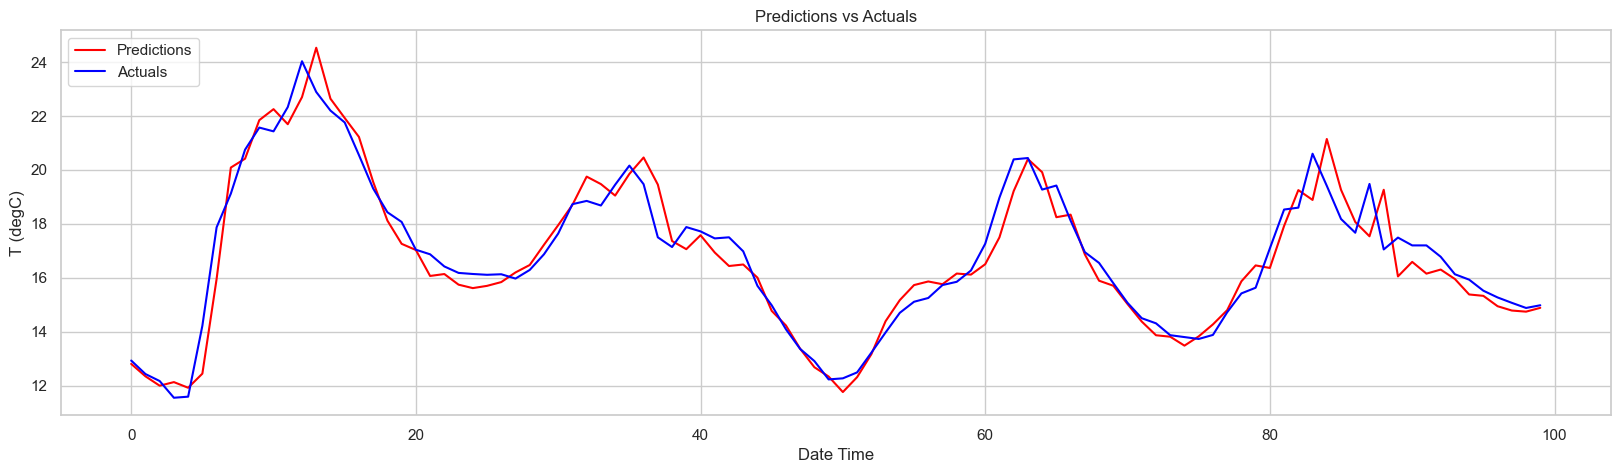

{'MSE': 0.46926503881347686,
 'RMSE': 0.6850292247878749,
 'MAE': 0.47297097098992374,
 'R2': 0.9932622534620148,
 'Adj_R2': 0.9932529618493737}

In [302]:
df_test, metrics_test = plot_predictions1(model6, X_test4, y_test4)
metrics_test

In [303]:
LSTM4_train = model_result('LSTM4', 'Training', metrics_train)
LSTM4_val = model_result('LSTM4', 'Validation', metrics_val)
LSTM4_test = model_result('LSTM4', 'Testing', metrics_test)
LSTM4_results = pd.concat([LSTM4_train, LSTM4_val, LSTM4_test], axis = 0)
LSTM4_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM4,Training,0.507485,0.712380,0.488228,0.992987,0.992986
0,LSTM4,Validation,0.402736,0.634614,0.445868,0.988757,0.988741
0,LSTM4,Testing,0.469265,0.685029,0.472971,0.993262,0.993253


### Adding both VPmax (mbar) and p (mbar) to the data as additional predictor variable

In [414]:
total_df = pd.concat([df['VPmax (mbar)'], df['p (mbar)'], temp_df], axis =1)
total_df

,VPmax (mbar),p (mbar),temp,day_sin,day_cos,year_sin,year_cos
Date Time,,,,,,,
2009-01-01 01:00:00,3.33,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,3.12,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,3.13,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,3.07,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,2.94,997.46,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...
2016-12-31 19:10:00,5.69,1002.18,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,5.51,1001.40,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,4.99,1001.19,-2.75,-0.675590,0.737277,0.008334,0.999965


In [415]:
random_seed = 42
np.random.seed(random_seed)

def df_to_X_y5(df, window_size=7): 
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][2]  
        y.append(label)
    return np.array(X), np.array(y)

In [416]:
X5, y5 = df_to_X_y5(total_df)
X5.shape, y5.shape

((70084, 7, 7), (70084,))

In [419]:
X_train5, y_train5 = X5[:60000], y5[:60000]
X_val5, y_val5 = X5[60000:65000], y5[60000:65000]
X_test5, y_test5 = X5[65000:], y5[65000:]

X_train5.shape, y_train5.shape, X_val5.shape, y_val5.shape, X_test5.shape, y_test5.shape

((60000, 7, 7), (60000,), (5000, 7, 7), (5000,), (5084, 7, 7), (5084,))

In [420]:
vpmax_train_mean2 = np.mean(X_train5[:, :, 0])
vpmax_train_std2 = np.mean(X_train5[:, :, 0])

p_train_mean2 = np.mean(X_train5[:, :, 1])
p_train_std2 = np.mean(X_train5[:, :, 1])

temp_train_mean4 = np.mean(X_train5[:, :, 2])
temp_train_std4 = np.mean(X_train5[:, :, 2])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - vpmax_train_mean2) / vpmax_train_std2
    X[:, :, 1] = (X[:, :, 1] - p_train_mean2) / p_train_std2
    X[:, :, 2] = (X[:, :, 2] - temp_train_mean4) / temp_train_std4
    return X

In [422]:
preprocess(X_train5)
preprocess(X_val5)
preprocess(X_test5)

array([[[ 0.54906167, -0.00895183,  0.9393132 , ...,  0.25881905,
          0.52287789, -0.8524076 ],
        [ 0.50854888, -0.0084058 ,  0.89473129, ...,  0.5       ,
          0.52226676, -0.85278217],
        [ 0.39805946, -0.00793056,  0.7673544 , ...,  0.70710678,
          0.52165537, -0.8531563 ],
        ...,
        [ 0.26547216, -0.0073441 ,  0.60176444, ...,  0.96592583,
          0.52043178, -0.85390325],
        [ 0.17855382, -0.00691941,  0.48500228, ...,  1.        ,
          0.51981958, -0.85427607],
        [ 0.13877762, -0.00668685,  0.42874416, ...,  0.96592583,
          0.51920712, -0.85464845]],

       [[ 0.50854888, -0.0084058 ,  0.89473129, ...,  0.5       ,
          0.52226676, -0.85278217],
        [ 0.39805946, -0.00793056,  0.7673544 , ...,  0.70710678,
          0.52165537, -0.8531563 ],
        [ 0.32881943, -0.00762722,  0.68243647, ...,  0.8660254 ,
          0.52104371, -0.85353   ],
        ...,
        [ 0.17855382, -0.00691941,  0.48500228, ...,  

In [423]:
model7 = Sequential()
model7.add(InputLayer((7,7)))
model7.add(LSTM(64))
model7.add(Dense(8, 'relu'))
model7.add(Dense(1, 'linear'))
model7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [427]:
filepath = r'C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint'
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cp7 = ModelCheckpoint(filepath+'\\model7.keras', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose =1)
model7.compile(loss = MeanSquaredError(), metrics = [RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0001))

In [428]:
model_7 = model7.fit(X_train5, y_train5, validation_data = (X_val5, y_val5), epochs = 100, callbacks = [cp7, early_stopping])
model_7 

Epoch 1/100
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.8335 - root_mean_squared_error: 8.8628
Epoch 1: val_loss improved from inf to 4.14725, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model7.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 82.1935 - root_mean_squared_error: 8.8249 - val_loss: 4.1472 - val_root_mean_squared_error: 2.0365
Epoch 2/100
1858/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1082 - root_mean_squared_error: 2.4620
Epoch 2: val_loss improved from 4.14725 to 1.51538, saving model to C:\Users\Al-Amin\Desktop\Data_Analyst_Projects\Python\LTSM Time Series Forecasting\Dataset\Model_Checkpoint\model7.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.0926 - root_mean_squared_error: 2.4586 - val_loss: 1.5154 - val_root_mean_squared_error: 1.2310
Epoch 3/100
1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8200 - root_mean_squared_error: 1.3476
Epoch 3: val_l

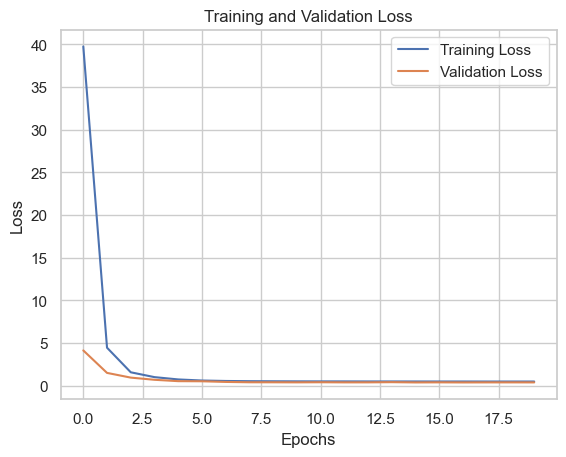

In [430]:
plt.plot(model_7.history['loss'], label='Training Loss')
plt.plot(model_7.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show();

In [432]:
model7 = load_model(filepath+'\\model7.keras')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step


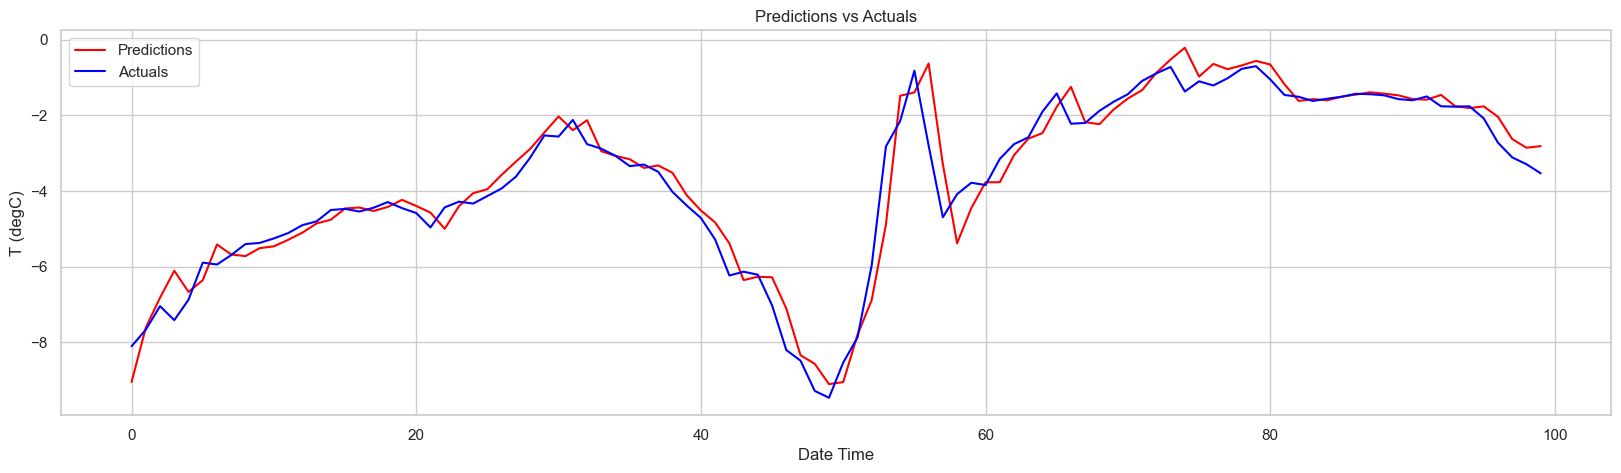

{'MSE': 0.49945803999300453,
 'RMSE': 0.7067234536882192,
 'MAE': 0.48369583598503474,
 'R2': 0.9930980431683358,
 'Adj_R2': 0.9930972378326607}

In [433]:
df_train, metrics_train = plot_predictions1(model7, X_train5, y_train5)
metrics_train

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


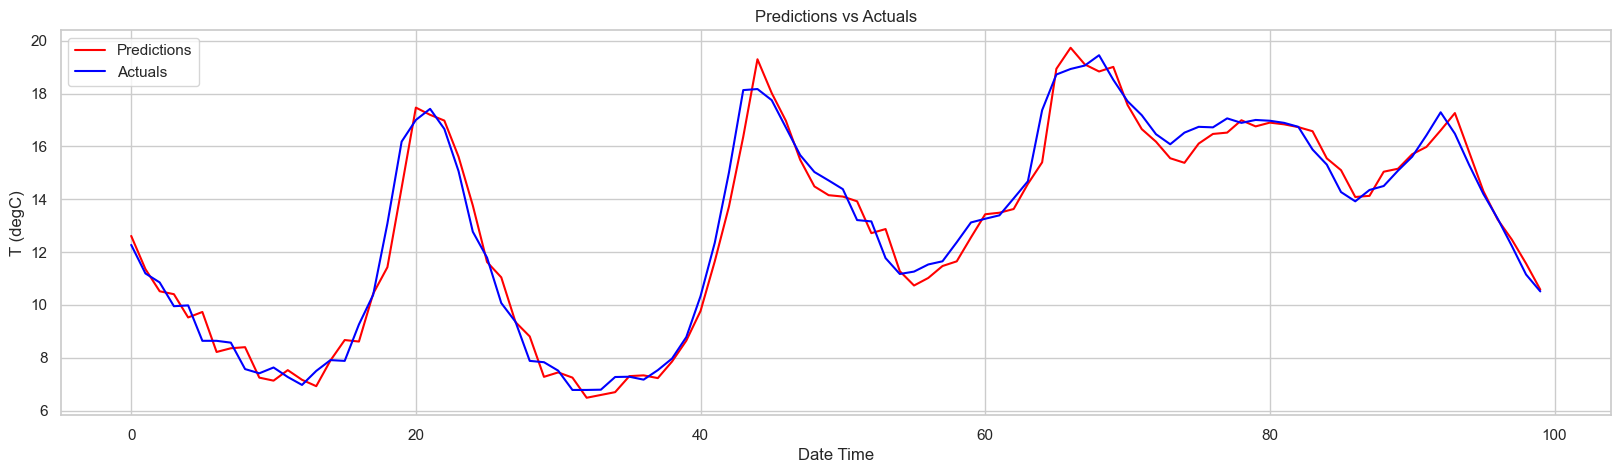

{'MSE': 0.39632559810735224,
 'RMSE': 0.629543960424808,
 'MAE': 0.44124018419289585,
 'R2': 0.9889356373568501,
 'Adj_R2': 0.9889201224252592}

In [434]:
df_val, metrics_val = plot_predictions1(model7, X_val5, y_val5)
metrics_val

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


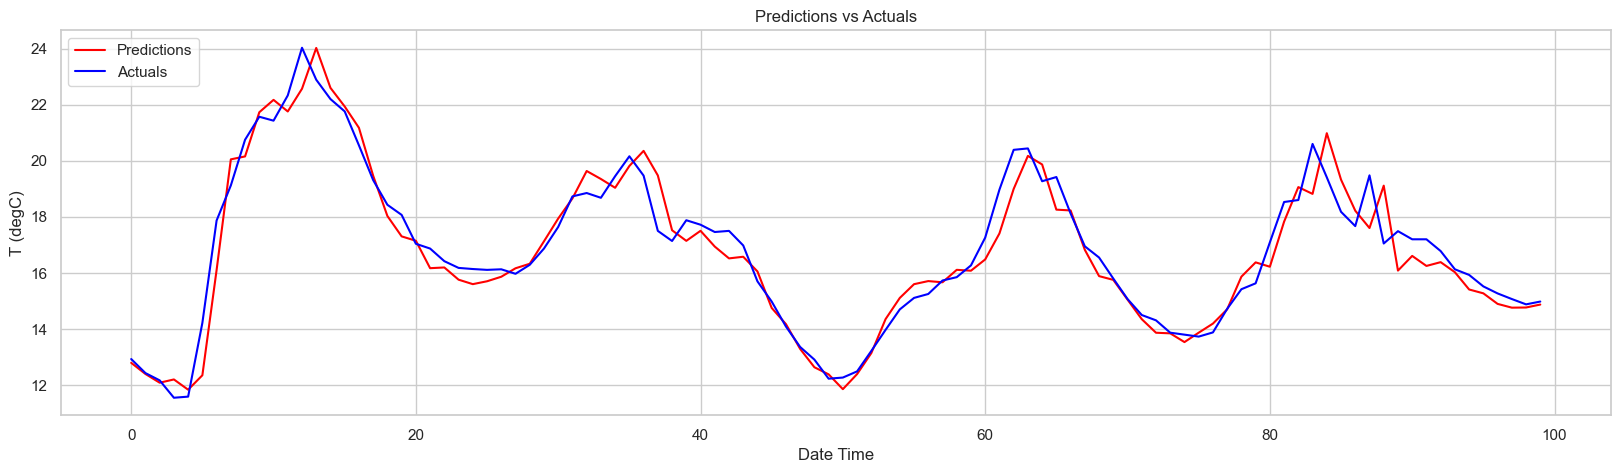

{'MSE': 0.4622515549601554,
 'RMSE': 0.6798908404737891,
 'MAE': 0.469571133353033,
 'R2': 0.9933629536477168,
 'Adj_R2': 0.9933538009045202}

In [435]:
df_test, metrics_test = plot_predictions1(model7, X_test5, y_test5)
metrics_test

In [436]:
LSTM5_train = model_result('LSTM5', 'Training', metrics_train)
LSTM5_val = model_result('LSTM5', 'Validation', metrics_val)
LSTM5_test = model_result('LSTM5', 'Testing', metrics_test)
LSTM5_results = pd.concat([LSTM5_train, LSTM5_val, LSTM5_test], axis = 0)
LSTM5_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM5,Training,0.499458,0.706723,0.483696,0.993098,0.993097
0,LSTM5,Validation,0.396326,0.629544,0.441240,0.988936,0.988920
0,LSTM5,Testing,0.462252,0.679891,0.469571,0.993363,0.993354


In [437]:
lstm_results_table = pd.concat([LSTM1_results, LSTM2_results, LSTM3_results, LSTM4_results, LSTM5_results], axis = 0)
lstm_results_table

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM1,Training,0.641376,0.800860,0.537009,0.991138,0.991138
0,LSTM1,Validation,0.486962,0.697827,0.481098,0.986406,0.986392
0,LSTM1,Testing,0.619207,0.786897,0.537091,0.991106,0.991097
0,LSTM2,Training,0.512588,0.715953,0.492368,0.992917,0.992916
0,LSTM2,Validation,0.406123,0.637278,0.450122,0.988662,0.988649
0,LSTM2,Testing,0.480672,0.693305,0.481434,0.993097,0.993089
0,LSTM3,Training,0.512120,0.715625,0.489744,0.992923,0.992922
0,LSTM3,Validation,0.399033,0.631691,0.441688,0.988860,0.988844
0,LSTM3,Testing,0.472502,0.687388,0.473693,0.993216,0.993206
0,LSTM4,Training,0.507485,0.712380,0.488228,0.992987,0.992986


### Determining and Evaluating the best LSTM Model 

To **determine** which LSTM model is the best among the five presented in the table, we should consider the evaluation metrics, particularly on the testing dataset. The key metrics to look at are Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²). The Adjusted R² (Adj_R²) is also important for models with multiple predictors.

**Lower MSE and RMSE:** Indicates that the model's predictions are close to the actual values. Lower values are better.

**Lower MAE:** Shows how far the predictions are from the actual values on average. Lower values are better.

**Higher R² and Adjusted R²:** Indicates that the model explains a higher proportion of the variance in the target variable. Higher values are better, with 1 being the maximum.

To **evaluate** which LSTM model generalizes best to the data and to identify any potential overfitting or underfitting, we should compare the performance of each model on the training, validation, and testing datasets.

**Overfitting:** Occurs when a model performs well on the training data but poorly on validation or testing data.

**Underfitting:** Occurs when a model performs poorly on both the training and validation/testing data.

**Generalization:** A model generalizes well if it performs consistently well across training, validation, and testing datasets.

**LSTM1 Analysis:**

There is a noticeable increase in MSE and RMSE from validation to testing, suggesting that the model may be overfitting. The performance on the training data is better than on the validation and testing data.

**LSTM2 Analysis:**

MSE and RMSE are relatively consistent from training to testing, with only minor increases. The model shows good generalization, with performance on testing being slightly better than on validation.

**LSTM3 Analysis:**

Similar to LSTM2, LSTM3 performs consistently well across training, validation, and testing, indicating good generalization with only slight variations in performance.

**LSTM4 Analysis:**

Shows consistent performance with minimal overfitting or underfitting. The metrics are relatively stable across training, validation, and testing.

**LSTM5 Analysis:**

LSTM5 performs consistently well across training, validation, and testing datasets. It exhibits very low MSE, RMSE, and MAE with high R² and Adjusted R², indicating good generalization with minimal signs of overfitting or underfitting.

**Best Model Based on Generalization:**

**LSTM5** is the best model among the ones listed. It has the lowest MSE, RMSE, and MAE on the testing set, and high R² and Adjusted R² scores. The performance across training, validation, and testing datasets is consistent, indicating that the model generalizes well and does not exhibit significant overfitting or underfitting.

In [439]:
LSTM5_results

,Model,Dataset,MSE,RMSE,MAE,R2,Adj_R2
0,LSTM5,Training,0.499458,0.706723,0.483696,0.993098,0.993097
0,LSTM5,Validation,0.396326,0.629544,0.441240,0.988936,0.988920
0,LSTM5,Testing,0.462252,0.679891,0.469571,0.993363,0.993354


We could delve deeper into model optimization by incorporating normalization and regularization techniques, as well as adding additional hidden layers. However, these enhancements are beyond the scope of this project. Therefore, we will conclude the project at this point.